In this short demo, I will show how to use the csPCR test on a simulated dataset.

In [11]:
'''
First, we generate a dataset, we can change the Alpha_s, Alpha_t and effect parameter to change the distribution of
the generated dataset.
'''

import numpy as np

def generate(ns, nt, p,q, s, t, u, Alpha_s=0, Alpha_t = 2,effect=1, x_effect=0, z_diff = 0.1):
    Zs_null = np.random.normal(0,1, (ns, q))
    Zt_null = np.random.normal(0,1, (nt, q))
    
    Z_source = np.hstack((np.random.normal(0, 1, (ns, p)) , Zs_null))
    Z_target = np.hstack((np.random.normal(z_diff, 1, (nt, p)) , Zt_null))
    
    X_source = Z_source[:, :p] @ u + np.random.normal(0, 1, ns)
    X_target = Z_target[:, :p] @ u + np.random.normal(0, 1, nt)

    V_source = Z_source[:, :p] @ s + Alpha_s * X_source + np.random.normal(0, 5, ns)
    V_target = Z_target[:, :p] @ t + Alpha_t * X_target + np.random.normal(0, 5, nt)
    
    # V_source = Z_source[:, :p] @ s + 2*X_source 
    # V_target = Z_target[:, :p] @ t - 2*X_target
    
    Y_source = (Z_source[:, :p].sum(axis=1))**2 + effect*V_source + np.random.normal(0, 1, ns)+ x_effect * X_source
    Y_target = (Z_target[:, :p].sum(axis=1))**2 + effect*V_target + np.random.normal(0, 1, nt)+ x_effect * X_target
    
    
    return Y_source.reshape(-1, 1), X_source.reshape(-1, 1), V_source.reshape(-1, 1), Z_source,\
           Y_target.reshape(-1, 1), X_target.reshape(-1, 1), V_target.reshape(-1, 1), Z_target


'''
According to the generation process, 
we write 2 functions to calculate the xz_ratio and true density ratio of the data
'''


# def true_density_ratio(X, Z, V, s=np.array([-0.5, -1.0,  0.3, -0.9, -1.5 ]), t=np.array([ 1.5, -0.2 ,  0.06 , -1.4, -0.5]),\
#                        p=5,q=50, Alpha_s = 0, Alpha_t = 0,z_diff = 0.1):
#     ratios = []
#     size = V.size
#     for i in range(size):
#         zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
#         vs_prob = norm.pdf(V[i], loc=Z[i][:p]@s + Alpha_s*X[i], scale =5)
#         zt_prob = multivariate_normal.pdf(Z[i][:p], mean = z_diff*np.ones(p), cov= 1*np.identity(p))
#         vt_prob = norm.pdf(V[i], loc=Z[i][:p]@t + Alpha_t*X[i], scale =5)
#         ratios.append((zt_prob*vt_prob)/(zs_prob*vs_prob))
    
#     return np.array(ratios)

'\nAccording to the generation process, \nwe write 2 functions to calculate the xz_ratio and true density ratio of the data\n'

In [12]:
'''
Define some parameters for data generation
'''
nt, p,q = 2000, 5, 50
est_size = 200
ns = est_size + 500
est_ratio = 500/ns
s = np.array([-0.5, -1.0,  0.3, -0.9, -1.5])
t = np.array([ 1.5, -0.2, 0.06 , -1.4, -0.5])
u = np.array([ 0.1, -1.1,  0.4, -0.6, -0.3])


In [13]:
from csPCR_functions import *

In [24]:
Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u,effect=1)

'''
Since this method is model_X framework, we assume that the X|Z,V and Z distribution are known. So we need to define three 
extra functions as the input of the test.
1. Model_X: Should be a function of the conditional model of X|Z,V
   Input: z, v values(float)
   Return: one X sample follows the X|Z,V distribution

2. E_X: Should be a function of the conditional expectaion of X|Z,V
   Input: z,v values(float)
   Return: the calculated conditional expectation E[X|Z,V]

3. xz_ratio: Should a function for calculating the (X,Z) density ratio (i.e. P_t(X,Z,V)/P_s(X,Z,V))
   Input: X, Z (ndarrays)
   
   Return: density ratio array (ndarray)
'''

def Model_X(z, v):
    # Conditional distribution of X|Z
    return z[:5] @ u + np.random.normal(0, 1, 1)

def E_X(z, v):
    # Conditional expectation of X|Z
    return z[:5] @ u



def xz_ratio(X, Z, z_diff = 0.1):
    ratios = []
    for i in range(X.shape[0]):
        zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
        zt_prob = multivariate_normal.pdf(Z[i][:p], mean = z_diff*np.ones(p), cov= 1*np.identity(p))
        ratios.append((zt_prob)/(zs_prob))
    
    return np.array(ratios)

'''
To use the Test function, need input of source and target X,Z,V and source Y data into the function,
Also take 3 functions mentioned above as inputs.
'''
Test(X_source, Z_source, V_source, Y_source, X_target, Z_target, V_target,\
     model_X = Model_X, E_X = E_X, xz_ratio= xz_ratio, test_size = 0.5, L=2)


[-0.         -0.90310395  0.         -0.37330108 -0.33328562  0.
 -0.          0.          0.         -0.          0.08004057 -0.
  0.         -0.         -0.31959864 -0.         -0.         -0.
  0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.          0.         -0.14688071
  0.          0.          0.          0.         -0.         -0.
  0.         -0.         -0.          0.         -0.0657709  -0.
  0.          0.         -0.         -0.          0.          0.
 -0.         -0.         -0.          0.         -0.         -0.
 -0.          0.3210817 ]
[ 1.39100626  0.          0.         -1.12108061 -0.35099297 -0.
 -0.         -0.         -0.06085499 -0.          0.          0.01588416
 -0.03969722 -0.          0.          0.          0.          0.
  0.         -0.07680353  0.         -0.         -0.         -0.
 -0.         -0.         -0.          0.          0.          0.
  0.         -0.         -0.          0.        

0.10559127082271114

In [10]:
Test_pe_true_dr(X_source, Z_source, V_source, Y_source, X_target, Z_target, V_target,\
     model_X = Model_X, E_X = E_X,  true_dr = true_density_ratio, L=2)

NameError: name 'true_density_ratio' is not defined

In [82]:
c= 0
nt, p,q = 500, 20,50
est_size = 10
ns = est_size + 500
est_ratio = 500/ns
# ns = 500

s = np.array([-1, -0.5, 0, 1, 1.5,-1, -0.5, 0, 1, 1.5,-1, -0.5, 0, 1, 1.5,-1, -0.5, 0, 1, 1.5])
t = np.array([ -1, -1, 0.5 , 0.5, 1,-1, -1, 0.5 , 0.5, 1,-1, -1, 0.5 , 0.5, 1,-1, -1, 0.5 , 0.5, 1])
# t = s
u = np.array([ 0, -1, 0.5, -0.5, 1,0, -1, 0.5, -0.5, 1,-1, -1, 0.5 , 0.5, 1,-1, -1, 0.5 , 0.5, 1])
# s = np.array([-1, -0.5, 0, 1, 1.5])
# t = np.array([ -1, -1, 0.5 , 0.5, 1])
# u = np.array([ 0, -1, 0.5, -0.5, 1])
# ns = 1000
def true_density_ratio(X, Z, V, s=s, t=t,\
                       p=p,q=q, Alpha_s = 0, Alpha_t = 0,z_diff = 0.1):
    ratios = []
    size = V.size
    for i in range(size):
        zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
        vs_prob = norm.pdf(V[i], loc=Z[i][:p]@s + Alpha_s*X[i], scale =5)
        zt_prob = multivariate_normal.pdf(Z[i][:p], mean = z_diff*np.ones(p), cov= 1*np.identity(p))
        vt_prob = norm.pdf(V[i], loc=Z[i][:p]@t + Alpha_t*X[i], scale =5)
        ratios.append((zt_prob*vt_prob)/(zs_prob*vs_prob))
    
    return np.array(ratios)
    # return np.ones(size)

def Model_X(z, v):
    # Conditional distribution of X|Z
    return z[:p] @ u + np.random.normal(0, 1, 1)

def E_X(z, v):
    # Conditional expectation of X|Z
    return z[:p] @ u

def xz_ratio(X, Z, z_diff = 0.1):
    ratios = []
    for i in range(X.shape[0]):
        zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
        zt_prob = multivariate_normal.pdf(Z[i][:p], mean = z_diff*np.ones(p), cov= 1*np.identity(p))
        ratios.append((zt_prob)/(zs_prob))
    return np.array(ratios)


for i in trange(100):
    Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u,Alpha_s=0, Alpha_t =0,effect=0,x_effeft_s=0, x_effect_t=2, z_diff = 0.1)

    p_value = Test(X_source, Z_source, V_source, Y_source, X_target, Z_target, V_target,\
    model_X = Model_X, E_X = E_X, xz_ratio = xz_ratio, test_size=est_ratio, L=3)
    # p_value = Test_true_dr(X_source, Z_source, V_source, Y_source, X_target, Z_target, V_target,\
    # model_X = Model_X, E_X = E_X,  true_dr = true_density_ratio, L=3)
    print(p_value)
    if p_value < 0.05:
        c += 1

  0%|          | 0/100 [00:00<?, ?it/s]

[-0.82271744  0.         -0.3214614   0.42636431  0.92341189 -0.39119542
 -0.09972812 -0.26329193  1.48162892  0.70068031  0.          0.24322026
 -0.07428008  0.28632348  0.49686291 -0.290852    0.         -0.
  0.          0.82850218  0.         -0.          0.         -0.
  0.          0.         -0.         -0.          0.         -0.
  0.         -0.         -0.          0.47430725 -0.          0.1273007
 -0.         -0.          0.1417628  -0.          0.         -0.
  0.         -0.          0.05010353 -0.         -0.         -0.
 -0.          0.          0.04029972  0.         -0.25496229  0.
  0.          0.         -0.          0.         -0.         -0.
  0.          0.          0.          0.14614238  0.          0.
 -0.14330255 -0.          0.         -0.          0.52047115]
[-0.51249112 -0.         -0.          0.47756319  0.         -0.29820087
 -0.00637231  0.          0.44256139  0.         -0.         -0.
  0.          0.05188442  0.         -0.         -0.         -

  1%|          | 1/100 [00:00<00:46,  2.12it/s]

0.18761104614403679
[-0.45296187  0.1295226  -0.          1.34395639  0.60737221 -1.17139672
 -0.         -0.          0.70646996  1.14620907 -0.28127875  0.
 -0.83701863  0.45046525  0.31995051 -0.          0.          0.
  0.4976915   0.88109359  0.          0.          0.02982104  0.
 -0.01479735 -0.         -0.         -0.          0.         -0.
  0.          0.         -0.         -0.         -0.         -0.
 -0.          0.          0.23141507  0.13764654 -0.05140609  0.27591888
 -0.          0.         -0.17585915 -0.         -0.         -0.
  0.          0.38963477 -0.         -0.1073487  -0.          0.
 -0.         -0.         -0.          0.04556985 -0.         -0.
  0.          0.70579599  0.2646121  -0.          0.         -0.14421267
  0.34685136  0.          0.20826533  0.25361272  0.77879433]
[-1.04677516  0.          0.          0.          0.         -0.99231089
 -0.          0.          0.19732546 -0.         -0.          0.
  0.         -0.          0.         -0. 

  2%|▏         | 2/100 [00:00<00:44,  2.20it/s]

0.8854464314902379
[-3.99312336e-01 -0.00000000e+00 -0.00000000e+00  9.80470528e-01
  8.56737697e-01 -6.72360253e-01  0.00000000e+00 -3.63847151e-01
  1.79963790e+00  0.00000000e+00 -5.13738296e-02 -0.00000000e+00
 -4.16071004e-01  3.21940386e-01  9.42570210e-01 -3.64234377e-01
  2.56333160e-01  0.00000000e+00  5.95866408e-01  3.58772153e-01
  5.78813141e-01  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -7.80626153e-01  0.00000000e+00  0.00000000e+00
 -3.43180271e-02 -2.23238535e-01 -2.67979808e-01 -2.83832896e-01
  1.23050995e-01  0.00000000e+00  8.24069257e-01 -0.00000000e+00
  1.91561479e-01 -1.29585909e-01  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  7.55596669e-01  2.05011970e-01
 -4.34621003e-01 -3.12153396e-02 -2.39615913e-02 -0.00000000e+00
  4.81892479e-01 -0.00000000e+00  1.34194456e-02 -3.93376624e-01
  0.00000000e+00 -1.15990429e-01 -0.00000000e+00 -1.58750675e-01
  3.77255820e-01  0.00000000e+00 -0.00000000e+00 -1.85936571e-02
 -0.00

  3%|▎         | 3/100 [00:01<00:43,  2.24it/s]

0.048914889356842406
[-0.41952658  0.         -0.          0.74616387  0.90403835 -0.95769815
 -0.         -0.09604702  0.33497071  0.54048709 -0.          0.
  0.          0.          0.48667177 -0.          0.         -0.
 -0.          0.31737281 -0.         -0.          0.          0.26342848
  0.04896116 -0.          0.          0.         -0.         -0.
  0.         -0.         -0.         -0.          0.         -0.
 -0.11333895  0.         -0.          0.          0.         -0.
 -0.14612902  0.         -0.         -0.          0.          0.
 -0.32765826  0.         -0.         -0.         -0.22998872 -0.
  0.          0.         -0.          0.         -0.          0.
 -0.176037   -0.          0.          0.          0.         -0.11606575
  0.         -0.         -0.          0.          0.6612994 ]
[-1.11145793 -0.         -0.          0.42466726 -0.         -0.88205549
 -0.16630823 -0.          0.36577831  0.          0.          0.
 -0.          0.          0.         -0.

  4%|▍         | 4/100 [00:01<00:42,  2.25it/s]

0.5964817274851453
[-0.31329659 -0.         -0.          0.48001028  0.59798477 -0.69621763
  0.         -0.03655678  0.68750924  0.29056731 -0.         -0.03271567
 -0.43633655  0.8830335   0.31870293 -0.          0.         -0.29519899
  0.26619923  0.44767834  0.          0.         -0.46570036  0.04547249
 -0.          0.          0.         -0.          0.04500668 -0.
  0.          0.00483849  0.07250744 -0.03412954  0.          0.
  0.         -0.          0.         -0.          0.         -0.30362335
 -0.          0.          0.12589286 -0.         -0.1970163   0.1777605
  0.17450166 -0.         -0.17423338  0.23741587 -0.          0.
  0.          0.         -0.030132    0.          0.          0.
 -0.          0.         -0.         -0.05318982  0.          0.04013863
  0.20568726 -0.00943984 -0.         -0.          0.67541253]
[-0.24174461 -0.13499298 -0.          0.85075365  0.0422242  -0.40647339
 -0.15031819  0.          0.8435934  -0.         -0.12713864 -0.
  0.5628966

  5%|▌         | 5/100 [00:02<00:42,  2.24it/s]

0.8818670190362017
[-1.27688809  0.         -0.          0.59679029 -0.         -0.37260025
  0.17245812  0.          1.10541012  1.2908584  -0.26626237 -0.15400292
 -0.          0.2811352   0.23400282 -0.12349694  0.          0.
  0.          0.30354695  0.          0.          0.01611115 -0.
  0.          0.          0.          0.          0.         -0.0226707
  0.16003978 -0.34673257 -0.21202922  0.          0.          0.19773346
  0.         -0.          0.         -0.         -0.47533219 -0.
 -0.         -0.          0.          0.         -0.          0.09989736
 -0.          0.          0.         -0.          0.         -0.
  0.         -0.          0.         -0.00598892  0.22475273  0.2325747
 -0.         -0.62792057  0.          0.01224203 -0.52946647  0.38970113
  0.         -0.53426944  0.         -0.          0.69091072]
[-0.8199525  -0.          0.          0.73297096 -0.         -0.78976801
 -0.11130248  0.          0.70880185 -0.         -0.         -0.
  0.        

  6%|▌         | 6/100 [00:02<00:41,  2.27it/s]

0.6160435804120115
[-0.75724058  0.         -0.09763539  0.94175559  1.0087207  -1.07231238
  0.         -0.05354771  0.5288949   0.9455296  -0.         -0.
 -0.71925905  0.46225126  0.32572259 -0.          0.          0.
  0.51412023  0.82090176  0.          0.          0.          0.
  0.25623672 -0.          0.2663338   0.          0.00415073 -0.
  0.         -0.         -0.         -0.          0.10982139  0.
 -0.          0.         -0.          0.          0.          0.
 -0.24281134 -0.         -0.07895449 -0.03277508 -0.          0.00732314
  0.         -0.          0.          0.         -0.15971299  0.01542774
  0.         -0.17995     0.06446022  0.          0.10934734 -0.00575491
 -0.         -0.          0.          0.         -0.20123709  0.
  0.         -0.17893658 -0.          0.36368353  0.56447335]
[-0.78771881 -0.          0.          0.49164497 -0.         -0.99466996
  0.          0.          0.58954962  0.         -0.         -0.
  0.          0.          0.      

  7%|▋         | 7/100 [00:03<00:41,  2.27it/s]

0.28291203477041016
[-0.98730918  0.23830178 -0.07086572  0.47914565  0.97287476 -1.00359736
  0.24288705 -0.0369554   0.61595883  0.35258998 -0.35950315  0.
 -0.          0.98494675  0.90857921 -0.2243231  -0.21049911  0.
  0.7522519   0.          0.          0.20547839  0.          0.
  0.01916539 -0.         -0.         -0.         -0.35625917 -0.15454929
 -0.13728964  0.39422309  0.44649046  0.         -0.35496943  0.05086153
  0.          0.06131716 -0.          0.         -0.13572577  0.
  0.4511064   0.54569318  0.         -0.          0.         -0.40119106
 -0.04583956  0.42738163 -0.15231772 -0.11028743  0.          0.
 -0.          0.          0.42864869 -0.0796718   0.         -0.
  0.30884488 -0.16072148  0.         -0.          0.09056163  0.
 -0.208142   -0.01867247  0.22792626  0.12423818  0.71676609]
[-0.59883781 -0.          0.          0.45506429  0.         -0.46932804
  0.02549374  0.          0.41685072  0.          0.         -0.
 -0.         -0.          0.28451

  8%|▊         | 8/100 [00:03<00:40,  2.28it/s]

0.549495947038656
[-1.38704952 -0.19375463 -0.22567163  0.58770797  0.         -0.64073425
  0.         -0.33050356  1.36887061  0.84790422 -0.02656586  0.10384994
  0.          0.79533535  0.61166384 -0.          0.27193761 -0.
  0.          0.75003472  0.30934587 -0.57748613 -0.         -0.
 -0.          0.         -0.          0.         -0.         -0.20367876
 -0.          0.30479774  0.         -0.          0.          0.
  0.         -0.08138956 -0.34968415  0.         -0.          0.
  0.46597468  0.27833338  0.          0.         -0.09002802  0.
  0.06505484 -0.          0.01288009 -0.23726273 -0.          0.
  0.07514389 -0.31335515 -0.         -0.          0.52269357 -0.
 -0.19960678 -0.          0.          0.11067811  0.          0.
  0.00614136  0.18000487  0.         -0.          0.72904274]
[-0.93870228 -0.10884363  0.          0.330514   -0.         -0.57259375
  0.03960251  0.          0.98940905  0.20945513 -0.31039535 -0.03675621
 -0.          0.          0.       

  9%|▉         | 9/100 [00:03<00:39,  2.29it/s]

0.6839204838854971
[-0.81882787 -0.         -0.10637767  1.24107026  0.75583676 -0.8379514
 -0.         -0.          0.19713917  0.63128358 -0.39835868  0.08698423
 -0.33455511  0.00308306  0.71004122 -0.51067663  0.         -0.56855963
  0.32269684  0.05707004  0.          0.02467674 -0.         -0.
  0.01983956  0.          0.          0.          0.         -0.
  0.20124513 -0.          0.         -0.         -0.06167191 -0.
  0.53287269 -0.         -0.06675598  0.          0.22531431  0.
 -0.         -0.          0.22533416 -0.          0.          0.
 -0.         -0.          0.         -0.         -0.20976818 -0.
  0.21764092  0.         -0.          0.          0.01779865  0.03632095
  0.11818331 -0.          0.07819197 -0.          0.05687144  0.14429999
  0.04000599 -0.28763876 -0.          0.          0.82043894]
[-0.65845225 -0.          0.          0.46310459 -0.         -1.11965144
 -0.         -0.          0.53882171 -0.         -0.         -0.
  0.          0.          0

 10%|█         | 10/100 [00:04<00:39,  2.29it/s]

0.7047114768404905
[-0.38139563  0.         -0.33558755  0.58836933  0.         -0.
  0.          0.          0.50637508  0.90504839 -0.          0.1512605
 -0.          0.30766134 -0.         -0.          0.         -0.
  0.51130221  0.42519158  0.          0.         -0.          0.
  0.          0.         -0.          0.          0.          0.
  0.          0.         -0.          0.         -0.         -0.
 -0.          0.          0.          0.          0.50790544 -0.
 -0.         -0.          0.          0.          0.         -0.
 -0.          0.         -0.          0.         -0.          0.
 -0.          0.          0.10181317  0.         -0.         -0.
  0.         -0.          0.          0.          0.         -0.
  0.          0.         -0.          0.          0.67691779]
[-0.9456115  -0.          0.          0.51833775  0.         -0.31501673
 -0.18062165  0.          0.44115636  0.         -0.         -0.13279497
 -0.          0.          0.          0.          0

 11%|█         | 11/100 [00:04<00:38,  2.29it/s]

0.047548771564157044
[-0.76806355  0.         -0.          0.64452358  0.98904327 -1.03449999
  0.         -0.          1.07582465  0.          0.         -0.
 -0.14848503  0.40309308  0.77406332 -0.          0.          0.
  0.          0.40957355 -0.07685897  0.          0.          0.
 -0.         -0.          0.          0.12638345 -0.07805119 -0.23362719
  0.          0.17928818  0.          0.          0.         -0.
  0.          0.         -0.          0.          0.          0.
  0.         -0.34183762 -0.         -0.08245725 -0.02187828 -0.
  0.          0.         -0.         -0.11228309  0.          0.
  0.         -0.         -0.         -0.          0.1681685   0.
  0.         -0.         -0.34673089 -0.          0.28722244 -0.
 -0.         -0.          0.04578535 -0.          0.69504689]
[-0.72299734 -0.44440145  0.          0.98134675  0.27308281 -0.34957768
 -0.07919897 -0.          0.41585584  0.         -0.          0.
  0.0556188   0.          0.24454085 -0.05866693

 12%|█▏        | 12/100 [00:05<00:38,  2.28it/s]

0.2796426187164932
[-0.48068696 -0.         -0.16818908  1.49626513  0.28623959 -0.15587169
  0.         -0.          1.28625072  0.21926835 -0.1270925   0.
 -0.50828996  0.42475576  0.          0.          0.         -0.
  1.02234782  0.45772601  0.         -0.         -0.         -0.03038575
  0.14934103 -0.         -0.         -0.         -0.         -0.
 -0.         -0.06139892 -0.10818878  0.          0.         -0.
 -0.0104387   0.          0.         -0.          0.         -0.
  0.06917877  0.          0.          0.          0.          0.
  0.23855023 -0.         -0.         -0.         -0.          0.26449512
 -0.         -0.         -0.02566901 -0.          0.          0.16040959
  0.          0.         -0.28041216 -0.         -0.         -0.
 -0.         -0.          0.         -0.          0.65389189]
[-0.69316595  0.         -0.00428256  0.62588757  0.2644945  -0.36042928
 -0.         -0.          0.62235127  0.         -0.         -0.
 -0.         -0.          0.      

 13%|█▎        | 13/100 [00:05<00:38,  2.27it/s]

0.0662897902640367
[-0.66339747  0.         -0.2939798   1.17868757  0.9381439  -0.45037193
 -0.         -0.          1.36041148  0.41552515 -0.39304926  0.
 -0.11267659  0.36619679  1.24998971 -0.02019756  0.         -0.
  0.69704583  1.02515112  0.          0.11124894  0.         -0.15914377
 -0.         -0.          0.          0.42843401 -0.          0.
  0.          0.02287344 -0.         -0.02301746  0.         -0.
 -0.         -0.         -0.          0.07807618 -0.          0.
 -0.08660852 -0.          0.         -0.14022269  0.          0.
 -0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.38444456 -0.          0.         -0.04119826 -0.
  0.         -0.         -0.          0.         -0.         -0.
  0.          0.          0.          0.07953275  0.48442542]
[-0.35134552 -0.         -0.          0.5945744  -0.         -1.09022982
 -0.         -0.          0.50683809  0.         -0.         -0.10047369
  0.          0.         -0.          0.  

 14%|█▍        | 14/100 [00:06<00:37,  2.28it/s]

0.11790378292673542
[-1.00496861  0.          0.          0.82191289  0.03205425 -0.7676436
 -0.         -0.          0.90679703  0.94561256 -0.          0.
 -0.01150136  0.69092666  0.44901551 -0.          0.62167998 -0.04510539
  0.1896482   0.48164387 -0.         -0.         -0.13332341  0.
 -0.          0.         -0.4807642  -0.         -0.          0.02532642
 -0.          0.          0.          0.20192983  0.          0.
 -0.         -0.          0.          0.          0.2334735  -0.33599328
 -0.          0.         -0.         -0.12506845  0.24201694 -0.
 -0.          0.         -0.          0.          0.17341544  0.
 -0.          0.         -0.05115873  0.          0.         -0.
  0.          0.         -0.          0.         -0.          0.
  0.          0.         -0.          0.05021143  0.76738199]
[-0.9710267  -0.          0.          0.75957591  0.         -0.77075892
 -0.         -0.          0.69730955 -0.          0.          0.
  0.         -0.          0.      

 15%|█▌        | 15/100 [00:06<00:37,  2.29it/s]

0.8886285323963478
[-0.77314934  0.         -0.          0.93360831  0.92842136 -0.42603371
  0.          0.          1.22888274  0.52650374 -0.58380234  0.
  0.          0.76805661  0.27913728 -0.          0.          0.
  0.07006015  0.478492   -0.07403367  0.         -0.          0.
  0.25166068 -0.         -0.          0.          0.          0.
  0.          0.         -0.         -0.         -0.         -0.
  0.10512292  0.         -0.0109933   0.          0.          0.
 -0.         -0.          0.13095508  0.          0.          0.07634743
  0.          0.         -0.11476499 -0.          0.          0.
  0.         -0.          0.          0.         -0.          0.
 -0.         -0.          0.         -0.          0.          0.0553473
 -0.05356244 -0.          0.          0.          0.62917661]
[-0.45332788  0.         -0.          0.29309498  0.         -0.67922219
 -0.          0.          1.01063672 -0.          0.         -0.
 -0.          0.         -0.         -0.119

 16%|█▌        | 16/100 [00:07<00:36,  2.31it/s]

0.007946977534971866
[-0.27649504 -0.         -0.          0.84093039  0.         -0.84676353
 -0.         -0.          0.63106128  0.1352879  -0.          0.
 -0.26863704  0.          0.51142617 -0.          0.22679368 -0.
  0.          0.         -0.          0.         -0.          0.
 -0.          0.25082637 -0.         -0.         -0.          0.
 -0.          0.          0.         -0.         -0.         -0.
  0.         -0.         -0.         -0.          0.02753474  0.
  0.         -0.          0.         -0.         -0.          0.
 -0.         -0.         -0.          0.         -0.          0.06679115
  0.         -0.20619888  0.          0.         -0.         -0.
 -0.          0.         -0.         -0.45534244  0.          0.070945
 -0.         -0.         -0.         -0.          0.95201987]
[-0.99599129  0.         -0.          0.33004561 -0.         -0.77728489
 -0.          0.          0.63970114  0.          0.         -0.45029819
 -0.          0.          0.028670

 17%|█▋        | 17/100 [00:07<00:35,  2.33it/s]

0.630991275436452
[-0.48838313  0.08410842 -0.20027675  1.35167061  1.01616333 -0.90396626
  0.         -0.          0.66568321  0.60426218 -0.14630731  0.
 -0.13123914  0.725664    0.8298228  -1.1305895  -0.         -0.
  0.69845567  1.12012337  0.         -0.03720022 -0.          0.
  0.          0.         -0.         -0.          0.          0.
  0.09067505 -0.34255962  0.         -0.         -0.2854877  -0.
 -0.09273667  0.          0.          0.28522842  0.32442582  0.
  0.          0.         -0.          0.08639784 -0.         -0.
 -0.         -0.22592009 -0.         -0.0634025  -0.         -0.
 -0.          0.00581087 -0.          0.          0.          0.38614584
 -0.          0.13724719  0.04253699  0.13187837  0.          0.
  0.         -0.          0.          0.          0.59744306]
[-0.95543547 -0.01738487 -0.0092433   0.48297445  0.         -1.15399686
 -0.19405188 -0.          0.39262635 -0.         -0.         -0.
  0.         -0.          0.         -0.54278659 -0

 18%|█▊        | 18/100 [00:07<00:35,  2.33it/s]

0.17967468919305052
[-0.00542662  0.         -0.          0.99206077  0.         -0.
  0.          0.          0.84339121  0.78997301 -0.         -0.
 -0.          0.          0.         -0.          0.         -0.
  0.          0.55142989  0.         -0.          0.         -0.
  0.          0.          0.         -0.         -0.          0.
  0.          0.         -0.11649921 -0.          0.         -0.
  0.          0.         -0.         -0.         -0.          0.
  0.         -0.          0.         -0.          0.          0.
 -0.          0.         -0.         -0.08883843  0.          0.
 -0.         -0.          0.          0.          0.         -0.
 -0.          0.          0.          0.         -0.          0.
 -0.          0.          0.         -0.          0.94828174]
[-0.84087994 -0.45100676 -0.06071749  0.77952738  0.56803723 -0.65197407
  0.1665462  -0.          0.75132885  0.75460456  0.         -0.
  0.04537912  0.          0.39133359 -0.25452829 -0.34835251  0.2

 19%|█▉        | 19/100 [00:08<00:34,  2.32it/s]

0.8798285063151786
[-0.01962299  0.         -0.          0.3731284   0.         -0.37972752
 -0.         -0.          0.90137489  0.66467988  0.          0.
 -0.46935416  0.28934962  0.3478593  -0.          0.          0.
  0.          1.00458163  0.         -0.          0.          0.
  0.          0.         -0.          0.          0.          0.
 -0.         -0.          0.          0.          0.         -0.49265468
  0.         -0.1519671  -0.         -0.          0.         -0.
  0.         -0.012537   -0.         -0.11156059  0.         -0.
 -0.          0.         -0.          0.          0.         -0.11677054
  0.         -0.27231584  0.          0.         -0.          0.
 -0.13675103  0.          0.         -0.         -0.          0.
  0.         -0.          0.          0.          0.65895408]
[-0.80693386 -0.          0.          0.58330341  0.         -0.36019093
  0.         -0.          0.76315495  0.         -0.13960784 -0.
  0.         -0.          0.         -0.13

 20%|██        | 20/100 [00:08<00:34,  2.31it/s]

0.9658806380126316
[-0.          0.         -0.          1.1343329   1.14299852 -0.91673675
 -0.          0.          1.01173012  0.         -0.25547776  0.
  0.         -0.          0.         -0.          0.28725987 -0.
  0.42172733  0.19523516 -0.19499803  0.1233341  -0.          0.
  0.         -0.          0.          0.         -0.         -0.
 -0.         -0.         -0.17740322  0.          0.          0.
 -0.         -0.          0.          0.          0.         -0.
  0.         -0.          0.         -0.          0.         -0.11396882
 -0.         -0.01807049 -0.          0.          0.         -0.05831846
 -0.         -0.          0.21900097 -0.         -0.         -0.1045733
 -0.08304958 -0.          0.         -0.         -0.          0.
 -0.          0.09222608 -0.         -0.22418961  0.71475923]
[-0.68154516  0.         -0.          0.29601388 -0.         -0.36646493
 -0.          0.          0.65994382  0.         -0.         -0.
  0.          0.          0.       

 21%|██        | 21/100 [00:09<00:34,  2.31it/s]

0.6236877548450455
[-0.          0.         -0.16359072  0.94374524  0.         -0.
  0.          0.          0.90978418  0.01348485 -0.          0.
 -0.          0.32530532  0.55723038 -0.          0.         -0.
  0.          0.         -0.         -0.          0.          0.03737334
  0.          0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.         -0.18784453  0.          0.47275672
 -0.         -0.          0.          0.          0.         -0.
 -0.         -0.          0.18753884 -0.          0.         -0.
 -0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.          0.         -0.
  0.          0.         -0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.95641141]
[-0.43597877 -0.         -0.          0.8670344   0.         -0.37783735
 -0.10209913  0.          0.68827421 -0.          0.         -0.
 -0.         -0.          0.         -0.         -

 22%|██▏       | 22/100 [00:09<00:34,  2.25it/s]

0.5191058329147682
[-0.90396063 -0.         -0.54880979  1.08089294  0.         -1.23522852
  0.         -0.27002393  1.26420772  0.61702706  0.         -0.1485048
 -0.          0.32676896  0.37214593  0.         -0.         -0.25922274
  0.          0.         -0.         -0.24094019  0.         -0.
 -0.1688901   0.         -0.18172546  0.         -0.29796113  0.
 -0.20278074 -0.01828829 -0.         -0.          0.37137073 -0.
 -0.         -0.         -0.          0.         -0.         -0.08230271
 -0.         -0.         -0.10576236 -0.         -0.11092502 -0.
 -0.         -0.          0.42741866  0.          0.         -0.
  0.          0.         -0.          0.15827834  0.          0.
 -0.          0.          0.          0.08584069 -0.          0.15318418
 -0.32994375 -0.         -0.         -0.          0.88438248]
[-0.49220507 -0.          0.06821533  0.58710474  0.         -0.71532126
 -0.         -0.          1.17524258  0.         -0.         -0.
 -0.         -0.          0

 23%|██▎       | 23/100 [00:10<00:39,  1.94it/s]

0.8924613584602045
[-0.45261697 -0.         -0.39271131  1.06140543  0.60619511 -0.27179134
  0.23100214  0.          0.30196973  0.22025686 -0.04647925  0.
 -0.          0.         -0.         -0.20138315  0.         -0.
  0.69503302  0.21720218 -0.          0.          0.         -0.20731073
  0.          0.00322856 -0.          0.          0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.
 -0.          0.45988131  0.         -0.          0.36405358 -0.
  0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.          0.
  0.          0.         -0.          0.          0.          0.
 -0.         -0.         -0.         -0.00671375  0.         -0.
 -0.          0.          0.02669301  0.          0.8195572 ]
[-0.71830198 -0.         -0.0297031   0.58739696 -0.04668889 -0.72934024
  0.         -0.          0.00405298  0.01143941 -0.47386132 -0.
 -0.          0.          0.         -0.48442387 -

 24%|██▍       | 24/100 [00:11<00:47,  1.60it/s]

0.10275181497822272
[-0.88082932  0.          0.          1.13697446  0.2008512  -0.73474799
  0.         -0.          0.89508338  0.56775011 -0.          0.
 -0.          0.64214733  0.73074345 -0.47543332 -0.          0.
  0.68812536  0.16752545  0.         -0.         -0.         -0.27719864
  0.         -0.11602751  0.60149932 -0.          0.          0.
 -0.          0.         -0.29856441  0.         -0.         -0.12451473
  0.16204778  0.         -0.          0.         -0.          0.09563663
 -0.         -0.          0.00479668 -0.          0.0900716   0.
 -0.01613428 -0.04806193  0.          0.         -0.         -0.
 -0.          0.00508614  0.         -0.         -0.          0.
 -0.          0.          0.          0.12284382  0.         -0.
 -0.          0.1145779  -0.          0.          0.73318216]
[-0.41656656 -0.          0.27041461  0.59530251 -0.         -0.35495829
 -0.          0.          0.53718642  0.10714538 -0.27703958  0.
 -0.          0.          0.01000

 25%|██▌       | 25/100 [00:12<00:52,  1.43it/s]

0.027728065751226993
[-6.30068314e-01  0.00000000e+00 -0.00000000e+00  1.09107897e+00
  2.82924692e-01 -6.33882418e-01  2.94445465e-01 -7.00061412e-02
  1.00675061e+00  3.01184750e-01 -8.07467299e-02 -0.00000000e+00
 -3.03911250e-01  3.53078086e-01  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  1.30059371e-01  4.43870094e-01
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -7.89007475e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.04282379e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -3.52588056e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  6.96992398e-02  6.93113340e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.03154240e-03 -0.00000000e+00
  0.00000000e+00 -4.30364665e-02  0.00000000e+00  0.00000000e+00
  0.

 26%|██▌       | 26/100 [00:12<00:51,  1.44it/s]

0.6750497437468763
[-0.35697057  0.         -0.          1.20394778  0.36428431 -0.94025385
  0.         -0.00761227  1.30095042  0.63556473 -0.17964906  0.
 -0.          0.60160594  0.58149941 -0.37760855  0.22027131 -0.
  0.25451013  0.61961226  0.         -0.         -0.          0.26808104
 -0.          0.          0.          0.          0.          0.
 -0.         -0.         -0.          0.         -0.          0.18699498
  0.         -0.         -0.         -0.         -0.          0.07329142
  0.          0.          0.         -0.2242452   0.          0.
  0.         -0.          0.         -0.07707821 -0.         -0.
  0.         -0.          0.         -0.          0.         -0.
 -0.          0.         -0.         -0.          0.          0.
 -0.         -0.          0.          0.          0.71374832]
[-0.49930138 -0.14954589  0.          0.47105956  0.         -0.33930004
 -0.          0.          0.54406559  0.         -0.          0.
 -0.         -0.          0.      

 27%|██▋       | 27/100 [00:13<00:49,  1.48it/s]

0.3418260072754178
[-0.56130624 -0.         -0.          0.97506332  0.49551057 -0.33884962
  0.15940654 -0.0164075   0.93410228  0.40384708 -0.19960538  0.
 -0.10060588  0.048383    0.31670677 -0.25400648  0.04667935 -0.
  0.55530702  1.35762512 -0.         -0.         -0.         -0.18981014
  0.         -0.13774221 -0.6468848  -0.          0.          0.
  0.23647707  0.13842267 -0.11660836 -0.31238627 -0.         -0.
  0.22538055 -0.16040133 -0.26623894  0.         -0.04714352  0.31467131
 -0.18775355  0.0363195   0.          0.50697875 -0.         -0.16108638
 -0.41635764 -0.          0.12862362 -0.          0.         -0.
  0.2855968   0.         -0.          0.         -0.13245298 -0.
  0.1506882  -0.2555168  -0.          0.          0.42278732  0.
  0.30861081 -0.         -0.40189402  0.          0.68782151]
[-0.54502325 -0.12172457  0.          0.35609064  0.         -0.65344849
  0.15597374 -0.          0.76031781  0.21387736 -0.         -0.
 -0.12571796  0.          0.070951

 28%|██▊       | 28/100 [00:13<00:46,  1.54it/s]

0.39231945978794225
[-0.54080928  0.         -0.          1.04507301  0.73867782 -0.19196743
  0.         -0.23822191  1.32828439  0.         -0.         -0.
 -0.57612272  0.53048668  1.33118708 -0.          0.         -0.04057769
  0.31577989  0.66825829 -0.          0.17830967  0.          0.
 -0.0333509  -0.         -0.          0.         -0.          0.07877221
 -0.          0.34887783 -0.18047504 -0.12084724  0.03774413  0.
 -0.          0.          0.36925324  0.15822235  0.          0.
  0.38918271 -0.2173477   0.         -0.         -0.1442763   0.07808669
  0.         -0.         -0.          0.2421483  -0.176452    0.66088681
  0.         -0.          0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.         -0.16065991 -0.08860461
  0.          0.         -0.         -0.          0.88913867]
[-0.78719717 -0.          0.          0.39230691  0.         -0.67354365
 -0.          0.01336679  1.03575206  0.         -0.         -0.
  0.          0. 

 29%|██▉       | 29/100 [00:14<00:43,  1.62it/s]

0.6307690786773106
[-0.71998351 -0.         -0.          0.82033977  0.         -0.80185278
 -0.         -0.          0.66769228  0.22606733 -0.2805102   0.
 -0.15765723  0.          0.46288748 -0.          0.         -0.35575234
 -0.          0.          0.          0.         -0.         -0.
 -0.         -0.10364674  0.          0.          0.         -0.
  0.         -0.         -0.35645265  0.         -0.20035475 -0.
 -0.         -0.          0.         -0.         -0.          0.08210938
  0.          0.         -0.         -0.          0.         -0.
  0.         -0.          0.          0.          0.06104328 -0.
 -0.         -0.          0.         -0.          0.          0.
 -0.          0.          0.          0.          0.         -0.
 -0.09364673  0.         -0.          0.          0.82622773]
[-0.194279   -0.          0.          0.04874293  0.         -0.93311717
 -0.         -0.          0.11276831  0.         -0.         -0.
  0.         -0.         -0.         -0.  

 30%|███       | 30/100 [00:15<00:41,  1.68it/s]

0.38158088642203203
[-0.77731825 -0.         -0.08634657  0.89944903  0.74352874 -0.47320656
 -0.         -0.43198902  0.55334564  1.13174547  0.          0.
 -0.          0.          0.4725594  -0.          0.          0.
  0.07250248  0.29085919 -0.         -0.         -0.         -0.04623774
 -0.          0.         -0.         -0.          0.         -0.
  0.         -0.          0.          0.          0.         -0.
 -0.16232719  0.          0.          0.09309755 -0.         -0.03348781
 -0.         -0.          0.          0.         -0.19532432  0.
 -0.          0.         -0.         -0.          0.          0.1431449
  0.          0.07562074  0.          0.          0.         -0.
 -0.         -0.          0.          0.          0.         -0.
  0.         -0.         -0.         -0.04182764  0.62541104]
[-1.07010313 -0.          0.          0.60287887  0.43791462 -0.86321263
 -0.29765744  0.          0.5260433  -0.2604666  -0.27735283 -0.10280187
  0.22602357 -0.          

 31%|███       | 31/100 [00:15<00:40,  1.71it/s]

0.8538630089721719
[-0.64502317  0.2417388  -0.35020502  1.03266962  1.07211105 -0.3676936
  0.         -0.          1.39695667  0.89352649 -0.42958943 -0.58358779
 -0.          0.20132411  1.41243146 -0.66397421 -0.         -0.
  0.18365836  1.25723118  0.02236154 -0.0333095   0.02828767 -0.
 -0.68531549  0.06568071  0.         -0.         -0.20811106  0.10207425
 -0.21359303 -0.          0.09733102  0.16927343  0.         -0.50441249
 -0.          0.08419965  0.21304642  0.18198794  0.43336231  0.18712971
 -0.22967749 -0.         -0.03758213 -0.00636369  0.30792631  0.1595832
 -0.         -0.32151035 -0.          0.          0.          0.23900048
 -0.17334449 -0.52764717  0.          0.03299243  0.          0.
  0.         -0.47978205 -0.          0.15396802 -0.         -0.28213283
 -0.          0.09392966  0.46665066 -0.          0.51555144]
[-0.76870122 -0.         -0.          0.1029215  -0.         -0.80050552
 -0.16302775 -0.          0.64047437  0.0218943  -0.         -0.22256

 32%|███▏      | 32/100 [00:16<00:39,  1.74it/s]

0.5498212031934749
[-0.76815925  0.         -0.43776624  0.71753364  0.1028647  -0.46354426
 -0.01606021  0.          1.36154379  0.75366469 -0.          0.
 -0.16142803  0.          0.11281306 -0.          0.         -0.
  0.83810055  0.42498685 -0.         -0.         -0.         -0.
  0.         -0.          0.          0.2827487   0.          0.22120849
 -0.         -0.         -0.         -0.          0.          0.
 -0.          0.          0.20228484 -0.         -0.         -0.
 -0.          0.08721202  0.         -0.         -0.          0.
 -0.         -0.          0.20884527  0.10408047 -0.2243415  -0.
  0.          0.         -0.19736929  0.         -0.12101943  0.
 -0.          0.         -0.          0.         -0.         -0.
  0.          0.         -0.         -0.          1.02317781]
[-0.66542801 -0.         -0.          0.74662934 -0.         -0.81452239
 -0.          0.          0.52338233  0.         -0.         -0.
  0.          0.          0.         -0.         -

 33%|███▎      | 33/100 [00:16<00:38,  1.75it/s]

0.46281984109836116
[-0.7814003  -0.          0.          0.29076321  0.18838176 -0.
  0.         -0.          0.7630464   0.68126025 -0.          0.
 -0.          0.          0.20738027  0.          0.         -0.
  0.          0.         -0.         -0.          0.27694669 -0.
 -0.          0.         -0.09407324  0.12941447  0.          0.32922951
  0.         -0.          0.          0.          0.         -0.
  0.         -0.14037407  0.          0.          0.          0.
 -0.         -0.          0.         -0.          0.          0.09086145
 -0.         -0.         -0.         -0.          0.         -0.
 -0.         -0.         -0.          0.         -0.12060508  0.
  0.          0.         -0.          0.         -0.16043597 -0.24734697
  0.          0.         -0.         -0.          0.74573444]
[-0.34430804  0.          0.          0.53932551 -0.         -0.4647912
 -0.         -0.          0.86382061  0.         -0.06026122 -0.
  0.         -0.          0.2406633   0.  

 34%|███▍      | 34/100 [00:17<00:36,  1.79it/s]

1.0
[-0.76493117  0.         -0.20088735  0.96898296  0.         -0.5568437
  0.30565757 -0.17785098  0.7287253   0.9006838  -0.10435386  0.
 -0.31156689  0.45912858  1.03265727 -0.54631747  0.         -0.08669583
  1.00508383  0.69915887  0.02002707 -0.          0.29872402 -0.
 -0.35344095  0.          0.         -0.03550506 -0.          0.1659626
 -0.         -0.         -0.19988307 -0.39910734  0.          0.03419719
 -0.         -0.05448266  0.         -0.0450275  -0.         -0.
  0.          0.13059582  0.          0.         -0.12606993 -0.
  0.          0.          0.          0.09331094  0.          0.03606527
  0.          0.25479838 -0.53053893  0.31321203 -0.15099425  0.11769905
  0.         -0.05474865  0.11481499 -0.         -0.07448082  0.
 -0.          0.         -0.         -0.          0.52401218]
[-0.35237784 -0.09829266  0.          0.64161218  0.03418529 -0.61879281
  0.         -0.          0.35755248 -0.         -0.          0.
  0.          0.07687196  0.1555849

 35%|███▌      | 35/100 [00:17<00:36,  1.77it/s]

0.40847072009564966
[-2.27798045e-01  0.00000000e+00  0.00000000e+00  1.00074433e+00
  4.14454560e-01 -9.32272363e-01  9.70616480e-02 -1.79085601e-01
  1.65081120e+00  1.55314395e-01 -0.00000000e+00  0.00000000e+00
 -1.21856465e-01  6.15772175e-02  8.72190246e-01 -1.09279776e-01
  1.91305114e-01 -1.34943784e-02  3.98562672e-01  6.36381581e-01
 -0.00000000e+00  1.08689377e-01 -0.00000000e+00 -6.29339094e-01
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -3.10534754e-01  1.43123245e-01  0.00000000e+00  4.70217645e-01
  6.38948263e-02  1.52135118e-01  1.98070795e-01 -5.09985800e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -7.15639109e-02  0.00000000e+00
  0.00000000e+00  1.54994966e-01 -0.00000000e+00 -9.36833473e-02
 -0.00000000e+00  0.00000000e+00 -3.93796006e-01 -0.00000000e+00
 -0.00000000e+00 -3.42180296e-01  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -4.01261056e-01  0.00000000e+00
 -0.0

 36%|███▌      | 36/100 [00:18<00:35,  1.81it/s]

0.6685553752645387
[-0.04142305 -0.         -0.25296118  1.33297349  0.39512744 -0.60629882
  0.         -0.16178343  0.7080275   0.16671215 -0.62423474  0.
 -0.          0.          0.68450442  0.         -0.          0.
  0.03502494  0.6407708  -0.          0.          0.          0.
  0.          0.          0.         -0.28691402  0.          0.
 -0.          0.         -0.          0.06910599  0.          0.
  0.          0.26673168  0.          0.          0.         -0.
 -0.         -0.         -0.          0.          0.         -0.04687712
  0.         -0.         -0.1107707   0.          0.15128533 -0.
  0.         -0.         -0.         -0.          0.         -0.
  0.         -0.         -0.05422127 -0.         -0.02759847 -0.16975543
  0.          0.         -0.         -0.          0.83880986]
[-0.83850654 -0.          0.          0.4085808  -0.         -1.02619762
  0.         -0.          1.29232671  0.         -0.         -0.
 -0.          0.09593255  0.         -0.  

 37%|███▋      | 37/100 [00:18<00:35,  1.79it/s]

0.2579030912304512
[-0.65037726  0.         -0.01940893  1.03105903  0.09296459 -0.8006651
  0.         -0.2053411   0.96740985  0.49904048 -0.05586707  0.
  0.          0.1914414   0.64439352 -0.4310248   0.08390938  0.
  0.          0.47390059 -0.          0.32132626 -0.15520594 -0.10815619
 -0.          0.         -0.08228829  0.         -0.          0.
 -0.4273236   0.          0.          0.          0.         -0.26046586
 -0.          0.23375562 -0.          0.13811765 -0.          0.
  0.         -0.          0.          0.          0.          0.
  0.         -0.          0.46200948 -0.          0.          0.4439903
  0.          0.          0.          0.          0.08114364 -0.
 -0.         -0.          0.         -0.         -0.          0.
  0.14129599  0.31946284  0.01335938 -0.          0.71855541]
[-0.75098954 -0.30595139 -0.01558052  0.69770418  0.37470328 -0.78410646
 -0.42708154 -0.          0.70371908  0.          0.         -0.37316393
 -0.          0.          0.

 38%|███▊      | 38/100 [00:19<00:34,  1.80it/s]

0.32257153810562034
[-0.79939796  0.         -0.30989483  1.49534355  1.1468811  -0.50790381
  0.         -0.          1.50410202  0.53771232 -0.         -0.
 -0.22439503  0.68905217  0.37229712 -0.05546125  0.         -0.12894074
  0.49159776  1.45880451  0.21076012 -0.          0.74962014 -0.27120718
 -0.11935128 -0.         -0.         -0.11836583 -0.         -0.16288388
 -0.         -0.46356987 -0.09882124  0.         -0.12755229 -0.44395197
 -0.          0.20586981 -0.25850553  0.01647731  0.38985022  0.
 -0.         -0.643487   -0.         -0.1642048   0.          0.
  0.31066771  0.          0.07113044  0.         -0.         -0.
 -0.         -0.          0.          0.16572709 -0.          0.
 -0.          0.          0.19265114 -0.33539497 -0.42481862  0.29649654
 -0.          0.          0.         -0.          0.53205243]
[-1.03696208  0.          0.          0.14652539  0.         -0.74344645
 -0.         -0.          0.22943542 -0.          0.         -0.
  0.          0. 

 39%|███▉      | 39/100 [00:20<00:34,  1.78it/s]

0.3075555152906815
[-0.86170491 -0.         -0.          0.96875656  0.         -0.55617042
  0.07336072 -0.5621524   1.00598308  1.20325609 -0.11303289 -0.
 -0.          0.37006955  0.18976517 -0.          0.01902641 -0.
  0.47047069  0.08649733 -0.         -0.          0.          0.
 -0.         -0.         -0.         -0.0488301   0.         -0.
  0.          0.         -0.         -0.07998946 -0.         -0.
 -0.          0.10726135 -0.09839567 -0.23917664 -0.         -0.01961722
  0.         -0.19622894 -0.          0.5111842  -0.         -0.
 -0.         -0.          0.         -0.02370457  0.06260967 -0.4067471
  0.54618603  0.          0.          0.          0.         -0.
  0.00569446  0.         -0.         -0.          0.         -0.10076602
  0.         -0.         -0.         -0.06374277  0.87668612]
[-0.14525179  0.17017207  0.          0.37090634 -0.         -0.68342626
 -0.02697188  0.          0.76000899  0.         -0.         -0.
  0.0149589   0.05467726  0.       

 40%|████      | 40/100 [00:20<00:33,  1.78it/s]

0.02592361705204893
[-0.13204476  0.          0.          0.90873241  0.23800897 -0.
  0.         -0.          0.61414641  0.          0.          0.
 -0.          0.24474734  0.03512053 -0.          0.09696372  0.
  0.02388446  0.2326495  -0.         -0.13602899  0.          0.
 -0.         -0.         -0.20413741  0.09993395 -0.         -0.
  0.00605205  0.         -0.          0.         -0.          0.
 -0.          0.          0.         -0.          0.          0.
  0.         -0.          0.          0.         -0.         -0.
  0.          0.          0.         -0.          0.          0.
 -0.         -0.          0.         -0.          0.18266772  0.
  0.         -0.          0.01128425 -0.          0.          0.
  0.          0.         -0.         -0.          0.74615936]
[-0.2084881  -0.          0.          0.24489263  0.         -0.89098839
 -0.          0.          0.63605207  0.          0.         -0.
  0.          0.          0.          0.         -0.          0.


 41%|████      | 41/100 [00:21<00:33,  1.75it/s]

0.6894068167173941
[-9.68973550e-01  6.22303835e-02 -1.66203097e-01  9.48855207e-01
  4.77389654e-02 -3.56718072e-01 -1.77740197e-01 -8.41003357e-02
  1.33618196e+00  1.64535514e-01 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  4.94716374e-01  6.74414564e-01 -1.12932737e-01
  0.00000000e+00 -1.23499192e-01  5.02387536e-01  7.92012029e-01
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.65701619e-02 -0.00000000e+00  2.64276312e-02  0.00000000e+00
 -0.00000000e+00  4.53620288e-01  0.00000000e+00 -2.52001556e-02
 -0.00000000e+00  2.85899402e-01 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  1.27921745e-03  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -6.08733843e-02 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.48979365e-02
 -2.42

 42%|████▏     | 42/100 [00:21<00:33,  1.76it/s]

0.9354010155401787
[-0.73393667  0.2044373  -0.04741676  0.5638993   0.66833071 -0.79833432
  0.         -0.          0.51461193  0.16533618 -0.06653139 -0.
 -0.17430839  0.06091165  0.71907949 -0.34683403  0.         -0.
  0.29769352  0.21609159 -0.24100796 -0.         -0.         -0.
  0.09424482  0.         -0.07269021 -0.          0.          0.
 -0.         -0.23064566  0.         -0.          0.01228552 -0.
  0.         -0.          0.03419704 -0.          0.          0.
  0.29359822 -0.         -0.          0.         -0.         -0.
  0.20347431  0.         -0.         -0.0202929  -0.         -0.
 -0.00750456  0.          0.         -0.         -0.          0.
  0.         -0.2665068   0.         -0.04268652 -0.          0.04975048
  0.          0.          0.          0.          0.81619991]
[-0.72905522 -0.07239335 -0.          0.33378359 -0.         -0.37237016
 -0.          0.          0.54202262 -0.         -0.         -0.
  0.         -0.          0.          0.         -

 43%|████▎     | 43/100 [00:22<00:32,  1.77it/s]

0.3919644172760157
[-0.75488019  0.         -0.          1.19316337  0.48740221 -0.61035934
  0.         -0.04527463  1.21907688  1.12249053 -0.68570366  0.
 -0.44832307  0.05501543  1.03929008 -0.17658825  0.         -0.30492575
  0.16496128  0.38909407 -0.          0.         -0.          0.
  0.16706095 -0.         -0.05705418  0.          0.         -0.
  0.44183026  0.00513406  0.         -0.         -0.          0.
  0.         -0.00787752  0.         -0.15461168 -0.          0.32415279
  0.          0.         -0.         -0.          0.21231663  0.
  0.09542678 -0.          0.08850175  0.          0.          0.
  0.          0.16725346 -0.         -0.          0.43120925  0.
  0.          0.         -0.          0.03243001  0.09902522  0.
  0.          0.         -0.16658678  0.          0.77264066]
[-6.37504622e-01 -0.00000000e+00 -0.00000000e+00  8.04057158e-01
  0.00000000e+00 -1.07728692e+00 -2.68337435e-01  0.00000000e+00
  5.46212087e-01  0.00000000e+00  0.00000000e+00 -

 44%|████▍     | 44/100 [00:22<00:31,  1.80it/s]

0.4387742738956609
[-0.61083901  0.         -0.33516643  0.93380775  0.40803429 -0.72197814
 -0.         -0.          0.94924122  0.79693823 -0.0519577   0.
 -0.08261137  0.28235227  0.80180779 -0.59184072  0.         -0.03991657
  0.52822712  0.75954618  0.          0.          0.          0.
  0.29454769 -0.          0.13789858  0.         -0.         -0.
  0.67056052  0.18327931  0.20847354  0.40777713 -0.         -0.
  0.         -0.00656976  0.         -0.09123027  0.         -0.
 -0.26946941  0.          0.0015985   0.          0.59985986  0.08250379
  0.54283305 -0.         -0.26920387  0.          0.13380828 -0.
 -0.          0.         -0.         -0.         -0.2273676   0.
  0.         -0.35161082  0.          0.09339998  0.17861958 -0.
  0.55866579  0.         -0.03620447  0.49466067  0.61089841]
[-0.55514228 -0.04493014 -0.          0.21046507  0.         -0.27785157
 -0.          0.          0.48729419  0.         -0.          0.
  0.         -0.          0.1234258   0.  

 45%|████▌     | 45/100 [00:23<00:30,  1.78it/s]

0.2198160588102347
[-0.22850306  0.         -0.27114378  0.88522232  0.72306161 -0.58647724
  0.056899   -0.          0.55143104  0.38442936 -0.37115894  0.
 -0.          0.08183984  0.89484562 -0.         -0.19961621 -0.03902866
  0.37665812  0.51507205  0.         -0.         -0.         -0.
 -0.         -0.31999393 -0.27536911 -0.         -0.          0.
 -0.15521843  0.          0.23352021 -0.          0.          0.
  0.15878527 -0.03087035 -0.65268515 -0.12412199 -0.         -0.
  0.          0.         -0.          0.          0.         -0.06528123
  0.5597111   0.          0.          0.00630886 -0.10017896  0.
 -0.          0.05440031 -0.         -0.         -0.          0.
  0.          0.          0.         -0.         -0.          0.
 -0.          0.          0.          0.          0.62712003]
[-0.45275132 -0.15218198  0.          0.48524573 -0.         -0.83393079
 -0.         -0.05927622  0.40498414  0.         -0.         -0.16359094
 -0.          0.02388287  0.      

 46%|████▌     | 46/100 [00:24<00:30,  1.78it/s]

1.0
[-1.12115036  0.         -0.19488708  1.18005012  0.54965191 -0.2266112
 -0.         -0.13403694  1.12877213  0.89729221 -0.         -0.
 -0.14757408  0.26591943  0.65039764 -0.85425716  0.          0.
  0.31221838  0.          0.          0.         -0.          0.
 -0.         -0.          0.2664356   0.          0.          0.00862652
 -0.         -0.06362548 -0.         -0.01474093  0.         -0.
 -0.          0.          0.          0.          0.          0.
 -0.          0.         -0.08003994 -0.          0.         -0.
  0.         -0.         -0.         -0.         -0.         -0.21876967
 -0.         -0.         -0.39119831 -0.          0.1247217   0.
 -0.         -0.01435607 -0.49152051 -0.          0.         -0.
 -0.         -0.17541713  0.10045155 -0.          0.71375237]
[-0.61869914  0.         -0.          0.65199377  0.         -0.68553692
 -0.05647101  0.          0.91694909  0.         -0.         -0.
 -0.          0.         -0.          0.         -0.      

 47%|████▋     | 47/100 [00:24<00:30,  1.74it/s]

0.5719921914260779
[-0.47408768  0.         -0.18095716  1.25459141  0.50128755 -0.24747344
  0.         -0.          0.67496028  1.03165353 -0.27028553  0.
  0.          0.98162867  0.39165219 -0.14758049  0.         -0.
  0.23394159  0.53341104 -0.          0.          0.4526821   0.
  0.         -0.          0.01073526 -0.         -0.          0.
 -0.          0.          0.          0.          0.         -0.
 -0.00914532  0.08300659  0.18928601  0.40505516  0.          0.25838837
 -0.          0.         -0.         -0.          0.          0.3014152
  0.12175658  0.          0.         -0.0514076   0.          0.
  0.05018718  0.34934787 -0.         -0.24966263  0.07611609 -0.20476258
  0.          0.          0.10819135 -0.          0.         -0.06137832
 -0.          0.          0.         -0.          0.5231708 ]
[-0.83247712 -0.         -0.          0.68960613  0.         -0.73392546
  0.         -0.          0.85315053  0.         -0.         -0.10730557
 -0.          0.   

 48%|████▊     | 48/100 [00:25<00:28,  1.79it/s]

0.31575055854407985
[-0.86606315  0.         -0.          0.82930832  1.0427621  -0.94919215
  0.05077643 -0.          0.61978062  0.7108209  -0.54796842  0.
  0.          0.34114917 -0.         -0.42695722  0.30169398  0.
  0.55317849  1.55196046 -0.         -0.         -0.08838233 -0.
 -0.01092655 -0.26650662  0.         -0.         -0.          0.
  0.54225416 -0.         -0.          0.          0.09688545  0.05642224
 -0.          0.         -0.13297617 -0.         -0.31015672  0.
  0.          0.          0.         -0.03082715  0.          0.
  0.14233301 -0.         -0.          0.          0.03190588  0.06752137
 -0.         -0.23688165  0.         -0.         -0.          0.41543837
  0.06029671 -0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.74402659]
[-0.10474395 -0.         -0.          0.40849479  0.         -0.49912286
  0.          0.          0.7306361   0.         -0.          0.
 -0.          0.          0.00888

 49%|████▉     | 49/100 [00:25<00:29,  1.75it/s]

1.0
[-0.0328142   0.         -0.          0.60037463  0.15238515 -0.42025891
 -0.         -0.          0.          0.          0.          0.
 -0.          0.12411326  0.24921531 -0.          0.         -0.
 -0.          0.          0.          0.          0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.          0.          0.          0.
 -0.         -0.         -0.          0.          0.          0.
  0.         -0.          0.         -0.          0.          0.
 -0.          0.          0.         -0.          0.         -0.
  0.          0.          0.         -0.         -0.         -0.
  0.         -0.          0.         -0.         -0.          0.
 -0.          0.         -0.         -0.          0.89929286]
[-0.15840828 -0.          0.          0.62665605 -0.         -0.70155439
 -0.          0.24977467  0.54854855  0.          0.         -0.
 -0.          0.          0.         -0.02887016 -0.         -0.
 -0.    

 50%|█████     | 50/100 [00:26<00:29,  1.67it/s]

0.3476907866101777
[-0.64448098 -0.         -0.          1.04567097  0.56558164 -0.33681113
  0.0840147  -0.          0.50280488  0.46397647 -0.63324398 -0.
 -0.          0.58468249 -0.         -0.          0.         -0.
  0.18610056  0.2632903   0.         -0.         -0.         -0.16803367
 -0.         -0.19487235 -0.54976836 -0.          0.          0.
  0.          0.         -0.         -0.          0.         -0.
  0.          0.          0.          0.         -0.04330114 -0.
  0.         -0.          0.          0.          0.         -0.
  0.37022533 -0.          0.09142405  0.05215589  0.17594438  0.
  0.02006302  0.          0.         -0.49248603 -0.08545179 -0.
  0.         -0.          0.         -0.1591184   0.         -0.06062048
 -0.09342381 -0.          0.00920034  0.          0.81798696]
[-0.23841466  0.         -0.          1.06380383  0.         -0.46314424
 -0.          0.          0.73449064  0.         -0.         -0.
 -0.          0.          0.          0.05

 51%|█████     | 51/100 [00:27<00:30,  1.60it/s]

0.14038492665325786
[-0.65650391 -0.         -0.          0.94329331  1.37318152 -1.40257959
 -0.          0.          0.60853581  1.04271898 -0.51309481  0.
 -0.12868406  0.59198559  1.07448425 -0.30740553 -0.         -0.
  0.70173671  0.          0.00524574 -0.07758334 -0.01177764 -0.
  0.          0.          0.         -0.         -0.          0.08363938
  0.         -0.23956449  0.         -0.30005983 -0.6261928   0.
  0.          0.          0.          0.          0.          0.
  0.00328399  0.          0.         -0.          0.         -0.12317936
  0.32875375 -0.          0.         -0.         -0.         -0.11404676
 -0.         -0.11330936  0.          0.          0.         -0.
  0.         -0.48553431  0.38139466  0.          0.1102494   0.
  0.         -0.         -0.          0.          0.48032855]
[-0.88129583 -0.06655985  0.04735564  0.47362309 -0.         -0.73943674
 -0.          0.          0.12149728  0.         -0.         -0.
 -0.          0.         -0.     

 52%|█████▏    | 52/100 [00:27<00:30,  1.56it/s]

0.8676400548645414
[-0.88527065  0.         -0.          0.76958514  0.15601698 -0.49294773
 -0.          0.          1.09546947  0.          0.          0.
  0.          0.50170217  0.03716638 -0.08610382  0.         -0.
  0.7735137   0.20224609 -0.31147334 -0.          0.19543612 -0.
  0.10186317  0.          0.          0.         -0.          0.
  0.          0.         -0.          0.          0.          0.
 -0.         -0.          0.          0.          0.         -0.42650108
  0.08846915  0.          0.06938947  0.07399244  0.         -0.20658128
 -0.01281568 -0.         -0.          0.          0.          0.
  0.06200317 -0.          0.38227623 -0.         -0.          0.
 -0.         -0.          0.          0.         -0.         -0.
  0.          0.          0.20106469  0.          0.75842105]
[-6.55747654e-01 -0.00000000e+00  0.00000000e+00  5.36250940e-01
  0.00000000e+00 -7.20375164e-01  0.00000000e+00 -0.00000000e+00
  4.14889312e-01  8.60932942e-02 -0.00000000e+00 -

 53%|█████▎    | 53/100 [00:28<00:28,  1.64it/s]

0.6985330523505835
[-0.62707142  0.          0.32003389  0.5615533   0.         -0.90101354
  0.         -0.1101049   0.84483107  0.12434815 -0.         -0.
 -0.02191047  0.29941594  0.35549404 -0.          0.         -0.3140529
  0.84300566  0.44922694  0.          0.         -0.         -0.
 -0.          0.14375868  0.         -0.14206119  0.         -0.45944379
 -0.          0.14187543 -0.         -0.03743314 -0.          0.
 -0.          0.          0.         -0.          0.15337453 -0.
  0.05219866 -0.          0.         -0.27244339  0.         -0.15275413
 -0.          0.          0.         -0.         -0.          0.
  0.         -0.         -0.          0.          0.         -0.
 -0.         -0.         -0.         -0.43875358  0.         -0.18541289
 -0.          0.         -0.00111049 -0.          0.66951083]
[-1.08148098 -0.          0.08392165  0.84749126 -0.0371432  -0.93652665
  0.38485021  0.          0.34664204 -0.12556849 -0.01133308 -0.40044454
  0.1677398   0.   

 54%|█████▍    | 54/100 [00:28<00:28,  1.60it/s]

max dr: 10.071917398341476
0.15881331753032146
[-0.21236872  0.         -0.          0.98691771  1.2060398  -0.89395968
  0.         -0.2188387   0.86438602  0.45228702 -0.57698786  0.
 -0.01239279  0.74081873  0.62388393 -0.         -0.         -0.
  0.62393236  0.80354313  0.          0.34000527  0.         -0.
  0.         -0.          0.          0.         -0.         -0.
  0.04439908 -0.          0.12451139  0.         -0.          0.
  0.          0.          0.10566321  0.          0.          0.
  0.         -0.19730566 -0.         -0.         -0.          0.26809252
 -0.         -0.          0.          0.         -0.         -0.
  0.          0.12774596 -0.          0.         -0.19429228 -0.
  0.09471919  0.27602131  0.          0.50617015  0.         -0.
  0.05973987  0.         -0.          0.09374978  0.60403821]
[-9.03208048e-01  0.00000000e+00  0.00000000e+00  4.33837988e-01
 -0.00000000e+00 -6.27567541e-01 -0.00000000e+00 -0.00000000e+00
  6.05381041e-01  0.00000000e+

 55%|█████▌    | 55/100 [00:29<00:26,  1.69it/s]

0.21962987583722482
[-1.07278294 -0.         -0.          1.36158005  0.4682338  -0.80888662
  0.         -0.          0.86575576  0.         -0.         -0.
 -0.1377225   0.34165947  0.1680958  -0.59992837 -0.         -0.42806279
  0.18057418  0.32389117  0.02300196 -0.10065651 -0.         -0.
 -0.18640065  0.         -0.          0.         -0.09025133  0.27468821
  0.11397964 -0.         -0.         -0.          0.         -0.13146321
 -0.          0.39415736 -0.          0.          0.26353447  0.0273926
  0.          0.          0.         -0.         -0.          0.
  0.         -0.          0.          0.         -0.          0.07658254
  0.         -0.         -0.07957963 -0.          0.         -0.33729875
 -0.         -0.         -0.00329226 -0.         -0.11894738  0.
 -0.40558415 -0.         -0.         -0.10104816  0.89576308]
[-0.88940011 -0.          0.39969659  0.37604568  0.0829579  -0.80973314
 -0.06082867  0.52919613  0.69257036  0.51677234 -0.05575695  0.
 -0.      

 56%|█████▌    | 56/100 [00:30<00:26,  1.65it/s]

0.547907083599848
[-0.80482901  0.          0.          1.34578471  0.43037551 -0.55794107
  0.         -0.          1.03426756  0.02080416 -0.         -0.
 -0.          0.40146618  0.64320737 -0.1751204   0.11981712 -0.
  0.29307906  0.32249611 -0.          0.          0.         -0.
  0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.         -0.          0.01541263 -0.30428384 -0.
  0.          0.          0.         -0.          0.0973736   0.07836082
 -0.          0.12693348 -0.         -0.0295417  -0.         -0.
  0.         -0.         -0.          0.          0.         -0.
  0.         -0.          0.          0.         -0.06456999  0.
  0.          0.         -0.          0.          0.         -0.
 -0.          0.         -0.27649654  0.01565694  0.7805207 ]
[-0.71180329  0.         -0.          0.38936661  0.29094927 -0.70543665
 -0.          0.04468222  0.         -0.         -0.         -0.36566535
  0.0471588  -0.         -0.         -0.   

 57%|█████▋    | 57/100 [00:30<00:26,  1.65it/s]

0.15575171631194185
[-0.60604467  0.         -0.          2.15036231  0.8701829  -0.59603555
  0.          0.          0.72689101  0.41081304 -0.          0.1534551
  0.          0.69716091  0.85572207 -0.          0.         -0.25518804
  0.96644811  0.89475417 -0.         -0.         -0.06207482 -0.
  0.          0.          0.          0.          0.         -0.
 -0.         -0.          0.          0.03206993 -0.0203632   0.
  0.          0.         -0.          0.         -0.          0.1944406
 -0.          0.         -0.38352915 -0.         -0.          0.
 -0.          0.          0.          0.         -0.          0.
 -0.         -0.          0.         -0.1596528  -0.10006891 -0.06424055
 -0.         -0.          0.         -0.06871612  0.         -0.
 -0.02460769 -0.185013    0.          0.          0.82988926]
[-8.16489171e-01 -0.00000000e+00  9.18705312e-02  3.20255065e-01
  0.00000000e+00 -5.65296289e-01 -0.00000000e+00 -0.00000000e+00
  1.11313908e+00 -0.00000000e+00 -1

 58%|█████▊    | 58/100 [00:31<00:33,  1.25it/s]

0.17423443055721044
[-1.57210366  0.41657423 -0.26194943  1.00048533  0.89683745 -0.70323448
 -0.02169352 -0.          1.36788554  1.05829224  0.          0.11784114
 -0.          0.29384642  0.35080686 -0.          0.40408432 -0.14691505
  0.58192524  0.46922975 -0.          0.         -0.          0.17614218
 -0.24874699 -0.61853248  0.23552314  0.15968562  0.         -0.
  0.          0.04586463 -0.          0.38486355  0.27101374  0.40937975
  0.         -0.         -0.         -0.         -0.         -0.
  0.19347927  0.         -0.          0.05068999  0.          0.
 -0.          0.11093556  0.          0.04108817 -0.02188567 -0.
 -0.03286437  0.         -0.         -0.          0.26964843  0.
  0.         -0.         -0.          0.         -0.28904368  0.
  0.         -0.          0.          0.3345988   0.72575291]
[-0.95511571 -0.32687746  0.          0.5218399  -0.02672267 -0.23315992
 -0.17231201  0.          0.7211341  -0.         -0.         -0.1068999
  0.31055696  0.07

 59%|█████▉    | 59/100 [00:32<00:35,  1.17it/s]

0.8230355735558496
[-0.83005077  0.         -0.42573801  0.64289277  0.76653484 -0.54174762
 -0.0641133   0.18211618  0.49482595  0.77500864 -0.12841209  0.
 -0.23549577  0.3975579   0.52518668 -0.35330486  0.         -0.32603844
  0.14518504  0.83362017  0.          0.         -0.         -0.
  0.          0.36447486 -0.37400786  0.          0.09454499  0.45248021
 -0.          0.22621486  0.          0.          0.         -0.
 -0.          0.         -0.         -0.         -0.36168097 -0.
 -0.          0.          0.          0.         -0.08771723  0.01738536
 -0.          0.          0.54396187 -0.          0.2058996   0.35287817
 -0.         -0.          0.          0.         -0.          0.
 -0.22218486  0.          0.          0.          0.03475934 -0.
  0.          0.          0.         -0.03305005  0.602594  ]
[-0.58578078 -0.15601681  0.28821006  0.76886776 -0.17708952 -0.49706292
  0.          0.          0.517964   -0.         -0.09197324 -0.
 -0.         -0.          

 60%|██████    | 60/100 [00:33<00:34,  1.17it/s]

0.5465061490278706
[-1.07336797 -0.         -0.05228896  0.75760772  0.84788465 -0.
  0.         -0.          0.7505586   0.14151215 -0.062084    0.24890993
 -0.          0.34324204  0.29521193 -0.33412549  0.         -0.1659618
  0.50991672  0.         -0.          0.          0.          0.
  0.          0.         -0.06225242 -0.         -0.         -0.
 -0.33785028  0.          0.          0.02511405 -0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.         -0.          0.          0.          0.         -0.
 -0.20705823 -0.         -0.         -0.          0.          0.00547112
 -0.         -0.          0.          0.          0.02557586  0.03564671
  0.          0.         -0.         -0.12731352  0.          0.
 -0.          0.          0.         -0.          0.6403572 ]
[-0.5263458   0.         -0.          0.33675431 -0.         -0.66636023
 -0.          0.          0.42800031  0.         -0.         -0.
  0.         -0.00276251  0.0188922

 61%|██████    | 61/100 [00:34<00:29,  1.30it/s]

0.07108782650048184
[-0.12098142 -0.         -0.          0.          0.84804249 -0.77019554
  0.         -0.          0.          0.25392231 -0.          0.
 -0.          0.          0.17888932 -0.07773745  0.         -0.
  0.48090514  0.70931966  0.          0.          0.          0.
  0.          0.         -0.37661575  0.          0.         -0.
  0.         -0.         -0.          0.1408489   0.         -0.
 -0.          0.          0.         -0.          0.         -0.
  0.          0.         -0.         -0.          0.         -0.
  0.         -0.         -0.          0.          0.          0.
 -0.          0.          0.          0.          0.         -0.04616565
 -0.         -0.          0.          0.         -0.          0.
 -0.          0.          0.          0.          0.57665743]
[-0.69424672 -0.         -0.          0.18254198 -0.         -0.52062469
 -0.0581624   0.          0.4842003  -0.         -0.15697668 -0.22669968
 -0.          0.09085929 -0.          0. 

 62%|██████▏   | 62/100 [00:35<00:28,  1.33it/s]

0.6265169979978973
[-0.87290116 -0.         -0.13438757  1.44226609  0.69042974 -0.47097111
 -0.         -0.          0.96131808  0.57540827  0.          0.25775415
 -0.          0.91522939  0.91294024 -0.04169244  0.         -0.89508214
  0.07460266  0.60612534 -0.         -0.          0.          0.
 -0.         -0.          0.          0.          0.          0.02750505
 -0.          0.         -0.35593888 -0.          0.         -0.
 -0.02499771  0.28278518 -0.          0.         -0.          0.03817493
 -0.         -0.         -0.         -0.          0.         -0.01420438
 -0.          0.         -0.          0.31539572 -0.          0.33481321
 -0.28918703  0.         -0.         -0.         -0.          0.
  0.00322854 -0.05083258 -0.          0.          0.          0.38634293
  0.         -0.         -0.          0.          0.79280427]
[-0.65540658 -0.          0.          0.64364895  0.         -0.38711019
  0.          0.          0.60739795  0.         -0.         -0.
 -

 63%|██████▎   | 63/100 [00:35<00:25,  1.42it/s]

0.4797575773223147
[-1.34424704e+00 -0.00000000e+00 -1.17279641e-01  1.05461889e+00
  2.88442634e-01 -1.12229391e+00  1.77440275e-01 -0.00000000e+00
  4.24609858e-01  3.48994523e-01 -3.96948090e-01 -0.00000000e+00
 -3.31233773e-01  4.97343612e-01  7.63652732e-01 -4.95454254e-01
 -0.00000000e+00 -1.87008379e-01  7.62889167e-01  1.36969629e+00
 -3.56282119e-01 -0.00000000e+00 -3.53839479e-01  9.17915783e-02
  0.00000000e+00  0.00000000e+00 -1.74110355e-01 -0.00000000e+00
 -0.00000000e+00  2.76597161e-01  2.76717888e-01  0.00000000e+00
 -2.99928419e-01 -5.71040090e-02  3.33668898e-02 -0.00000000e+00
  0.00000000e+00 -4.36055019e-01 -1.81019623e-01 -1.75260535e-01
  3.56875056e-01  4.03463900e-01 -0.00000000e+00  0.00000000e+00
  7.53389110e-03 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  1.22784370e-01  0.00000000e+00
  8.41773387e-04  2.58538696e-01 -2.34498576e-01 -0.00000000e+00
  2.36623165e-01 -0.00000000e+00 -1.46011182e-01  0.00000000e+00
  2.01

 64%|██████▍   | 64/100 [00:36<00:27,  1.33it/s]

0.07107684837967365
[-0.59115021 -0.         -0.          1.59931404  0.74690702 -0.45516859
  0.01632536  0.          1.20101277  0.70109013 -0.59522662  0.05294499
 -0.46288837  0.61294874  1.26064663 -0.         -0.         -0.05649744
  0.13775201  0.26959551 -0.02188475 -0.          0.46888099  0.0695691
 -0.          0.         -0.2338388   0.          0.         -0.
 -0.35636332 -0.          0.          0.          0.         -0.
  0.         -0.00806309  0.21449716 -0.          0.         -0.
  0.          0.15530432  0.          0.         -0.09901754 -0.10943
  0.          0.         -0.17065629 -0.         -0.          0.1701873
 -0.33575989  0.09222539  0.22680527  0.13643299  0.          0.
  0.10607637 -0.         -0.15404907 -0.         -0.5171069  -0.454019
 -0.         -0.         -0.          0.34102446  0.66535013]
[-0.55550872  0.          0.          0.24671069  0.         -0.58112085
 -0.          0.02821013  1.00144701 -0.         -0.         -0.
  0.          0.

 65%|██████▌   | 65/100 [00:37<00:25,  1.39it/s]

0.05746474189722728
[-1.12780656 -0.         -0.          0.6007045   1.05703772 -1.46204474
  0.26408941 -0.          1.11448315  0.4713945  -0.06430887 -0.01100116
 -0.43966124  0.47975659  0.5655429   0.         -0.         -0.
  0.54522868  0.09540333  0.          0.01881993 -0.          0.04567174
  0.1033057  -0.         -0.          0.         -0.         -0.03707219
  0.         -0.          0.27721275  0.          0.         -0.
  0.         -0.          0.         -0.         -0.29648212 -0.
  0.          0.08414532  0.          0.43154301  0.06696044 -0.
  0.          0.          0.          0.          0.2393101   0.
 -0.         -0.08570642 -0.02914741  0.          0.          0.
 -0.          0.         -0.08527507 -0.          0.         -0.
 -0.          0.         -0.          0.          0.64765071]
[-0.54040762 -0.         -0.          0.64370289 -0.         -0.60060962
 -0.21076451 -0.          0.53365478  0.         -0.         -0.
 -0.          0.          0.     

 66%|██████▌   | 66/100 [00:37<00:24,  1.37it/s]

0.7773913175706886
[-0.72566069  0.09075253 -0.10338765  1.06178159  0.38961993 -0.40300274
  0.         -0.49681616  1.68271843  0.22686192  0.         -0.
 -0.54333488  0.          0.67909525 -0.          0.         -0.2401824
  0.14156591  0.69717115 -0.13591416 -0.          0.          0.
  0.         -0.76032236 -0.         -0.14336064  0.         -0.07715191
  0.          0.22075799 -0.24855278  0.         -0.          0.
  0.08711823  0.00981689 -0.38140588  0.54210556 -0.         -0.
 -0.         -0.         -0.          0.         -0.12579908  0.16320438
  0.         -0.09507034  0.58287018  0.         -0.12402484  0.13586426
  0.34933725  0.         -0.          0.          0.         -0.
  0.          0.          0.25242871  0.          0.05085926 -0.
 -0.         -0.0089301   0.16994057 -0.          0.68397897]
[-0.33233353  0.          0.          0.58735249  0.16967594 -1.05833583
  0.         -0.          0.85793341 -0.         -0.         -0.17866133
 -0.          0.   

 67%|██████▋   | 67/100 [00:38<00:23,  1.38it/s]

0.11222620400403405
[-0.51777301  0.         -0.          1.62839611  0.92787429 -0.61422046
  0.         -0.2315401   1.06311439  1.07128342 -0.06400201 -0.
 -0.31250294  0.93466547  0.88193791  0.          0.12339591  0.10149633
  0.96878363  0.59520314  0.         -0.         -0.         -0.04463162
  0.          0.         -0.02157418  0.         -0.          0.
 -0.38938078  0.         -0.18753622 -0.         -0.          0.07712267
  0.34654732  0.          0.          0.          0.         -0.
  0.         -0.12107614  0.          0.43234465 -0.         -0.
 -0.39801947  0.36526114  0.          0.         -0.         -0.
 -0.          0.          0.          0.          0.          0.
 -0.13911645  0.         -0.16620197  0.         -0.04201266 -0.
 -0.          0.26717624 -0.         -0.39316078  0.46366972]
[-0.79391143 -0.          0.41307181  0.6226809   0.062474   -0.85745928
  0.          0.15740343  0.46366225  0.11232739  0.         -0.11801084
 -0.          0.52189247 

 68%|██████▊   | 68/100 [00:39<00:22,  1.44it/s]

0.37389645244578107
[-1.35597704e+00  4.57735340e-02 -5.09039295e-01  7.30889457e-01
  9.10334023e-01 -4.16276353e-01 -0.00000000e+00  0.00000000e+00
  1.31843478e+00  7.53107099e-01 -1.27736414e-01  0.00000000e+00
  0.00000000e+00  1.38717568e-01  4.08250617e-01 -9.76085534e-02
  0.00000000e+00 -1.14280031e+00  5.28017870e-01  8.02071178e-01
 -0.00000000e+00  0.00000000e+00 -3.08400183e-01  1.61522368e-01
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -6.39927143e-01
 -2.54891900e-02 -0.00000000e+00  0.00000000e+00 -1.03955277e-01
 -0.00000000e+00  0.00000000e+00  3.38763541e-01  2.74622349e-01
  0.00000000e+00 -5.76168652e-01 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  4.04169158e-04 -0.00000000e+00 -3.25246011e-02
 -9.70800088e-02 -5.12166436e-01  5.79915336e-01 -0.00000000e+00
 -1.17885399e-01 -0.00000000e+00  0.00000000e+00  7.49758771e-01
 -2.00231467e-01  2.62453833e-01 -0.00000000e+00 -4.43571079e-02
 -1.43043204e-01  0.00000000e+00  1.29257818e-01  0.00000000e+00
  8.5

 69%|██████▉   | 69/100 [00:40<00:21,  1.44it/s]

0.3187179525465347
[-0.76171403  0.12447673 -0.14001725  0.24680878  0.44622553 -0.43104679
 -0.          0.          1.09750789  0.0369513  -0.          0.
 -0.          0.53797308  0.42996984 -0.         -0.         -0.
  0.26441476  0.         -0.         -0.         -0.05841012 -0.
 -0.03676508 -0.         -0.         -0.23295058 -0.2119639   0.
  0.         -0.          0.         -0.          0.          0.25667686
 -0.         -0.          0.         -0.         -0.         -0.02381345
  0.         -0.         -0.          0.          0.          0.
  0.04979011  0.         -0.         -0.         -0.          0.
  0.          0.37109695 -0.          0.         -0.          0.
 -0.06781646 -0.          0.         -0.         -0.         -0.
  0.01431442 -0.         -0.          0.          0.72885452]
[-5.74110776e-01 -0.00000000e+00  0.00000000e+00  5.63827104e-01
  0.00000000e+00 -6.69430998e-01 -0.00000000e+00  0.00000000e+00
  1.97030546e-01  0.00000000e+00 -0.00000000e+00  

 70%|███████   | 70/100 [00:40<00:20,  1.47it/s]

0.3867506923693558
[-0.80762831  0.00242772 -0.28955946  1.42795507  0.90288069 -0.36877037
  0.          0.          0.57148456  0.70884367 -0.31082976  0.
 -0.          0.10502946  0.53268349 -0.15349566  0.         -0.30649998
  0.4452691   0.45407454 -0.         -0.          0.          0.35261608
 -0.         -0.          0.          0.         -0.          0.
 -0.11020105 -0.08877026 -0.12572777 -0.2952047   0.         -0.
 -0.03956472 -0.          0.         -0.          0.         -0.28372441
  0.          0.         -0.02889376  0.12593536  0.22930441 -0.
  0.02474365 -0.          0.         -0.         -0.         -0.
 -0.         -0.1960274  -0.          0.          0.22979901 -0.02551977
  0.          0.          0.01049404  0.          0.          0.27701091
 -0.         -0.39720173  0.         -0.          0.78982386]
[-4.76609644e-01  0.00000000e+00 -0.00000000e+00  4.08082991e-01
  0.00000000e+00 -5.29725759e-01  0.00000000e+00  0.00000000e+00
  2.58260820e-01  0.000000

 71%|███████   | 71/100 [00:41<00:19,  1.46it/s]

0.9785351732496359
[-0.79032288 -0.         -0.          1.08165411  0.56916537 -0.46981029
  0.         -0.          0.65635194  0.          0.1965336   0.
 -0.18608299  0.          0.83190098 -0.          0.         -0.
  0.          0.5741354  -0.0882461  -0.06484264 -0.00626313  0.28742094
 -0.          0.         -0.         -0.05005521  0.         -0.
  0.          0.          0.          0.09185691  0.12545106 -0.
  0.         -0.         -0.          0.          0.          0.
  0.32965664 -0.         -0.         -0.34593713 -0.00572793 -0.
  0.          0.          0.          0.         -0.         -0.
 -0.22530932 -0.          0.          0.         -0.         -0.
 -0.         -0.02557393  0.         -0.         -0.         -0.
  0.          0.         -0.          0.          0.93736325]
[-0.35969784  0.          0.          0.77270608  0.         -0.7893712
 -0.          0.          0.49910427  0.         -0.         -0.
  0.         -0.          0.         -0.         -0

 72%|███████▏  | 72/100 [00:42<00:20,  1.35it/s]

1.0
[-0.29203558  0.         -0.          1.22178029  0.1124223  -0.
  0.          0.          0.68346961  1.04464908 -0.         -0.00401084
 -0.          0.87844534  0.52243176 -0.          0.14901697 -0.14154718
  0.          0.35704523  0.          0.          0.          0.15227773
  0.         -0.20525386 -0.         -0.          0.          0.06419103
  0.         -0.          0.         -0.12411054  0.         -0.
  0.          0.          0.          0.         -0.         -0.
  0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.         -0.
  0.         -0.          0.          0.04105016  0.          0.
 -0.          0.          0.          0.08545362 -0.         -0.
 -0.         -0.          0.          0.          0.67197008]
[-0.68246075 -0.0190203   0.11640845  0.82373418 -0.         -0.86112131
 -0.02732527  0.          0.29390987 -0.         -0.         -0.05482736
  0.          0.          0.         -0. 

 73%|███████▎  | 73/100 [00:43<00:20,  1.31it/s]

0.06819117410227182
[-0.78704375  0.          0.          1.29695997  0.03462773 -0.58588037
 -0.         -0.          0.96651947  0.59401547 -0.          0.
 -0.          0.27662335  0.16392914  0.          0.         -0.
  0.6142503   0.37887632 -0.         -0.35359782  0.          0.
 -0.         -0.22401519  0.          0.         -0.         -0.
  0.         -0.         -0.03849965 -0.          0.          0.04852095
 -0.          0.         -0.          0.          0.          0.
  0.          0.         -0.10831804  0.26684685  0.18242716 -0.
 -0.          0.25577652 -0.         -0.          0.23597272  0.
  0.          0.          0.         -0.19281302  0.          0.
 -0.         -0.         -0.         -0.          0.         -0.
  0.          0.11783414 -0.         -0.          0.8238652 ]
[-5.57805036e-01  4.70363906e-02  1.76751121e-01  6.15372637e-01
  2.62580973e-01 -5.79399281e-01 -0.00000000e+00 -0.00000000e+00
  5.04712756e-01  0.00000000e+00  0.00000000e+00 -1.60333

 74%|███████▍  | 74/100 [00:44<00:22,  1.17it/s]

0.18754877082664878
[-0.8834349   0.51261844 -0.13526031  1.53324856  0.16012941 -0.72669172
  0.         -0.          0.92865288  0.51257693 -0.          0.
 -0.353407    0.34253018  1.02693678 -0.45258251  0.          0.0426615
  0.82658429  0.04446758 -0.22300989  0.         -0.          0.53558855
  0.          0.32159438 -0.12911719  0.         -0.          0.
 -0.          0.          0.         -0.63283182  0.         -0.
 -0.         -0.          0.          0.          0.10401202  0.
 -0.          0.         -0.00929599  0.          0.          0.
 -0.          0.         -0.         -0.          0.25501801 -0.00928072
 -0.         -0.3047179  -0.         -0.0130434  -0.          0.
 -0.          0.         -0.          0.         -0.01460035  0.04351032
 -0.05291893 -0.          0.          0.          0.86913011]
[-0.36361032 -0.         -0.          0.89303577  0.         -0.5434812
 -0.          0.          0.73984522  0.         -0.          0.
  0.19335189  0.          0

 75%|███████▌  | 75/100 [00:44<00:20,  1.21it/s]

0.03676616677246125
[-0.10811441 -0.         -0.          0.50813302  0.95212091 -0.77957942
  0.         -0.24172274  0.66196801  0.73579548 -0.73874419  0.
  0.08409878  0.41286888  0.27342457 -0.          0.         -0.
  0.46207399  0.59110751  0.62023006  0.          0.          0.
 -0.          0.00294027  0.          0.          0.         -0.
 -0.         -0.         -0.01684761  0.01975302  0.         -0.06257529
 -0.          0.         -0.          0.         -0.19211218  0.09385928
  0.00484578 -0.2879464   0.0799883  -0.          0.          0.
  0.04920808 -0.         -0.         -0.         -0.         -0.
  0.          0.          0.         -0.          0.          0.00932453
  0.          0.         -0.2278856  -0.          0.          0.
  0.00200197 -0.10550446  0.          0.20214438  0.58198788]
[-0.7468908  -0.          0.          0.41014423  0.38273945 -0.76557032
 -0.          0.          0.76717036  0.         -0.         -0.49304797
  0.20147993  0.36352653 

 76%|███████▌  | 76/100 [00:45<00:18,  1.28it/s]

0.48926287507553756
[-0.28214119  0.         -0.48328212  0.94089274  0.06412669 -0.19241131
 -0.          0.          1.90636606  0.44257884  0.         -0.
 -0.23390169  0.19866492  0.76685516 -0.         -0.         -0.4180215
  0.24850636  0.          0.05527043  0.          0.          0.
 -0.0954422   0.          0.          0.         -0.         -0.
  0.         -0.          0.         -0.          0.          0.
  0.         -0.23744493 -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.18938425 -0.
 -0.          0.         -0.          0.         -0.2008925   0.
 -0.          0.          0.          0.          0.         -0.
  0.          0.          0.46585908  0.          0.         -0.05766679
  0.          0.         -0.          0.          0.87662251]
[-0.77374544 -0.         -0.          0.57031902  0.         -0.89818856
 -0.         -0.          0.57592206 -0.         -0.         -0.05747395
 -0.          0.         -0.      

 77%|███████▋  | 77/100 [00:46<00:17,  1.29it/s]

0.7535891623660416
[-0.53286755  0.          0.          0.76571911  0.67202598 -0.65153465
 -0.         -0.59736367  1.04877467  1.02575075  0.          0.28930321
  0.          1.21864986  0.16376905 -0.32087257 -0.0824649  -0.38378368
  0.49271574  0.50404784 -0.20795216 -0.          0.01376925  0.
  0.04419144  0.          0.03522328  0.56734362 -0.10316416  0.34612078
 -0.         -0.22570492  0.17082454 -0.         -0.         -0.28295847
  0.17350998 -0.         -0.          0.          0.         -0.03171397
 -0.         -0.28947793  0.         -0.         -0.20333141 -0.03474672
  0.         -0.          0.25283566  0.         -0.         -0.
 -0.          0.          0.          0.5851513   0.15761943 -0.
  0.58525185 -0.          0.         -0.22957692  0.07992851  0.00895631
 -0.          0.         -0.         -0.          0.81075588]
[-1.03234319 -0.56242635 -0.00524356  0.69860699  0.56279314 -0.73486242
 -0.48197951  0.18705062  0.52486853 -0.07100318  0.         -0.233

 78%|███████▊  | 78/100 [00:47<00:17,  1.29it/s]

0.07799719591223409
[-0.49152315  0.         -0.17166349  0.76227933  1.47266879 -0.48193082
 -0.         -0.          1.04668232  0.4848894  -0.27258594 -0.
 -0.          0.67393321  0.61350884 -0.          0.33535058 -0.68175187
  0.20349438  1.03897034  0.          0.         -0.          0.
 -0.04198705 -0.         -0.          0.          0.         -0.
  0.         -0.00549983  0.23579555 -0.         -0.          0.
 -0.49806059  0.         -0.          0.          0.          0.
 -0.45257331  0.15478013 -0.07797786  0.24120842 -0.         -0.
  0.05770559  0.05406489  0.         -0.          0.         -0.
  0.03446629  0.          0.10481123 -0.          0.         -0.
 -0.          0.          0.40754597 -0.          0.          0.
  0.         -0.          0.          0.02805317  0.65057011]
[-0.72060275 -0.02587181 -0.          0.50964011  0.         -0.32365678
 -0.29088288  0.          0.33980013  0.25475851 -0.          0.
  0.          0.          0.         -0.         

 79%|███████▉  | 79/100 [00:47<00:15,  1.31it/s]

0.647289106650503
[-6.05244983e-01  0.00000000e+00 -4.75034219e-01  8.25432926e-01
  2.54802774e-01 -6.79744355e-01 -3.52347438e-02 -5.59994811e-01
  8.08491449e-01  7.78586775e-01 -0.00000000e+00 -0.00000000e+00
 -2.10664083e-01  3.02300247e-01  1.73243867e-01 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  4.70182335e-01 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -2.86152401e-03  0.00000000e+00 -0.00000000e+00
 -4.63044968e-01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.79385111e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.37247172e-01 -6.87473394e-01 -2.91305297e-02  0.00000000e+00
 -0.00000000e+00  1.45082716e-02 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.46457080e-01 -3.30517655e-01
  0.00000000e+00  1.40429792e-01  5.05194316e-01 -2.12948445e-01
 -3.237

 80%|████████  | 80/100 [00:48<00:14,  1.39it/s]

0.7480565492706572
[-0.40573168 -0.04063719 -0.          0.81178539  0.10908492 -0.12406452
  0.         -0.07864417  0.73841416  0.42187215  0.          0.
 -0.          0.110306    0.07359078 -0.         -0.         -0.
  0.31683784  0.17453634  0.         -0.         -0.02903109  0.
  0.          0.          0.          0.         -0.         -0.
  0.          0.          0.         -0.         -0.          0.
 -0.          0.         -0.         -0.         -0.         -0.
  0.          0.         -0.         -0.          0.         -0.42119913
 -0.         -0.         -0.          0.          0.         -0.
  0.         -0.          0.         -0.          0.         -0.
  0.         -0.          0.         -0.         -0.          0.
 -0.         -0.         -0.          0.          0.7064395 ]
[-0.78673456 -0.         -0.          0.63081446  0.0496432  -0.92650863
 -0.         -0.          0.05400236 -0.         -0.         -0.01574013
  0.         -0.          0.26112449 -0.  

 81%|████████  | 81/100 [00:49<00:13,  1.43it/s]

0.6473533287530648
[-0.          0.         -0.          1.19533597  0.36822914 -0.55485731
  0.         -0.          1.26291476  0.54191018 -0.07183128  0.
 -0.          0.14809288  0.72371478 -0.0186615   0.         -0.
  0.43028445  0.64053466 -0.         -0.09272161 -0.         -0.
 -0.          0.          0.16289568 -0.         -0.          0.02140546
  0.19338044 -0.         -0.         -0.49064466 -0.          0.
  0.          0.         -0.01244709  0.         -0.03759831 -0.07943585
 -0.          0.          0.          0.          0.03504305  0.
 -0.          0.          0.         -0.          0.          0.
 -0.         -0.         -0.         -0.          0.          0.
  0.         -0.          0.         -0.0520269   0.         -0.
 -0.          0.          0.04015354  0.          0.71854728]
[-0.69210121 -0.         -0.          0.46810411  0.         -1.11063958
 -0.          0.          0.46988403 -0.         -0.          0.
  0.         -0.          0.          0.  

 82%|████████▏ | 82/100 [00:49<00:12,  1.46it/s]

0.7706041840696216
[-0.8782582  -0.         -0.          0.84468162 -0.         -0.63633463
  0.         -0.14679906  0.93312232  0.69277029 -0.          0.
 -0.          0.          0.         -0.          0.          0.
  0.          0.43929214  0.          0.          0.         -0.
 -0.          0.         -0.          0.         -0.         -0.
  0.         -0.          0.          0.          0.         -0.
  0.         -0.53985561  0.          0.         -0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.
  0.          0.         -0.         -0.          0.092803    0.03858728
 -0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.          0.          0.          0.97256388]
[-0.60291409 -0.          0.          0.73421683  0.         -0.77517145
 -0.         -0.          0.33441685  0.         -0.         -0.
  0.21293192 -0.          0.         -0.30398833 -

 83%|████████▎ | 83/100 [00:50<00:11,  1.48it/s]

max dr: 3.7775160760660182
0.46236016764445553
[-6.48465205e-02  1.89820115e-01  0.00000000e+00  8.75261197e-01
  5.36241720e-01 -5.28718033e-01  0.00000000e+00  0.00000000e+00
  5.84592308e-01  5.76081482e-01  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  3.25679131e-01  3.03462419e-01 -2.34056458e-01
  0.00000000e+00 -3.15416963e-01  4.49619430e-01  2.97493786e-01
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  2.19699140e-02 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -6.65280956e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.34587093e-04 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -6.39379006e-03 -0.0000000

 84%|████████▍ | 84/100 [00:50<00:10,  1.53it/s]

0.3455348555968023
[-0.40149987 -0.         -0.16123837  0.89695949  1.21182988 -0.98007293
 -0.          0.          1.51460053  1.24154756 -0.          0.
 -0.21591376  0.6361864   0.37859624 -0.          0.         -0.
  0.35448892  0.84067595  0.          0.         -0.          0.
 -0.         -0.17471763  0.29904437  0.          0.         -0.
 -0.40012196  0.          0.         -0.         -0.          0.
 -0.37677274 -0.          0.39468845 -0.22493012 -0.          0.
  0.         -0.33204132  0.          0.55371247  0.44430374 -0.
 -0.60282669 -0.27139435  0.          0.08615503  0.         -0.04398038
  0.          0.          0.          0.          0.00976857 -0.11087049
  0.14647937 -0.40776212  0.          0.52725447 -0.          0.31299091
  0.          0.          0.          0.          0.69552419]
[-0.31647647  0.         -0.          0.49948652  0.         -1.19562903
 -0.         -0.          0.57637648  0.         -0.         -0.
  0.         -0.          0.026408

 85%|████████▌ | 85/100 [00:51<00:09,  1.57it/s]

0.21084496691623267
[-0.59836682 -0.         -0.          0.80302214  0.23823294 -0.37575243
 -0.          0.          1.20078608  0.          0.         -0.
 -0.          0.3233026   0.         -0.10135146  0.         -0.
  0.20604474  0.          0.         -0.08152837  0.          0.
 -0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.          0.         -0.
 -0.          0.          0.         -0.          0.         -0.
  0.         -0.         -0.         -0.          0.         -0.
 -0.          0.          0.          0.         -0.          0.
  0.          0.         -0.          0.         -0.          0.
 -0.          0.         -0.         -0.          0.          0.
  0.         -0.         -0.          0.          0.85040014]
[-0.84982166 -0.          0.10359515  0.52080824  0.         -0.87857909
  0.          0.          0.44009226 -0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.29981

 86%|████████▌ | 86/100 [00:52<00:08,  1.65it/s]

0.49684085572329717
[-1.08744458  0.16170986 -0.          0.52636895  0.         -0.50468225
  0.         -0.          0.98734184  0.         -0.          0.
 -0.79100122  0.11285652  0.40819093 -0.16096582  0.         -0.
  0.12781714  0.          0.          0.          0.         -0.
  0.          0.          0.          0.         -0.          0.
 -0.10597955  0.          0.05669731 -0.         -0.          0.
 -0.         -0.         -0.         -0.          0.         -0.
 -0.          0.          0.         -0.          0.13903529 -0.
 -0.         -0.10433142 -0.         -0.         -0.          0.14328087
  0.         -0.         -0.         -0.          0.          0.
  0.          0.22481794  0.          0.         -0.         -0.
 -0.         -0.         -0.12237435 -0.          0.86452148]
[-0.76177022 -0.          0.          0.31907933 -0.         -0.64767116
 -0.          0.0699368   0.85905451  0.         -0.         -0.
  0.24950903 -0.          0.32314992  0.         

 87%|████████▋ | 87/100 [00:52<00:08,  1.61it/s]

0.25122208779001864
[-0.78123984 -0.         -0.29539041  0.76065415  0.55973801 -0.76598671
 -0.         -0.10338604  1.00958563  1.11686484 -0.22710782  0.12012777
 -0.01154935  0.          0.85226274 -0.          0.         -0.
  0.23605116  0.222825    0.          0.         -0.         -0.
  0.          0.06045843  0.25087015  0.         -0.          0.
 -0.         -0.         -0.          0.          0.21373058 -0.
 -0.          0.         -0.         -0.          0.          0.
 -0.14425936 -0.28281031  0.         -0.          0.          0.
  0.         -0.          0.          0.          0.08393611  0.
 -0.17073767 -0.         -0.          0.          0.          0.
  0.28119896  0.         -0.          0.         -0.          0.15634288
  0.          0.         -0.40108746 -0.          0.57537693]
[-0.95906711 -0.         -0.          0.58303372  0.107559   -0.9324992
  0.         -0.          0.59602114  0.          0.         -0.
  0.          0.         -0.          0.  

 88%|████████▊ | 88/100 [00:53<00:07,  1.66it/s]

0.19795806951211015
[ 0.         -0.         -0.          1.19923584  0.         -0.41398803
 -0.         -0.42251122  0.43152043  0.36976358 -0.18404621 -0.
 -0.38925382  0.10189435  0.89530484  0.          0.         -0.08597872
  0.26946672  0.          0.15063621  0.          0.          0.
  0.05471493 -0.         -0.         -0.         -0.23179783 -0.54031384
 -0.2476927   0.23214364  0.          0.01776183 -0.         -0.04005126
 -0.         -0.08810018  0.          0.         -0.          0.
  0.          0.         -0.41820084  0.          0.30921536 -0.
  0.         -0.         -0.          0.          0.          0.
  0.          0.13235001 -0.          0.22724443  0.          0.
 -0.         -0.16119398  0.         -0.          0.          0.
 -0.         -0.         -0.         -0.          0.82479063]
[-1.01359266 -0.          0.04298672  0.89603389  0.         -0.15978497
 -0.         -0.          0.42918094  0.         -0.          0.
  0.          0.          0.     

 89%|████████▉ | 89/100 [00:53<00:06,  1.66it/s]

0.5820496390776091
[-0.75134899  0.          0.          0.62172725  0.41004187 -0.50494022
  0.2827921   0.          0.83819222  0.75984379 -0.54487144  0.
 -0.38938592  0.21929556  0.98906669 -0.          0.15504576 -0.
  0.42160011  0.54307955  0.         -0.         -0.13907818 -0.
  0.          0.          0.         -0.         -0.         -0.
  0.         -0.01396416  0.         -0.         -0.         -0.
 -0.15351036 -0.         -0.         -0.13957795  0.          0.
 -0.10724464  0.         -0.          0.          0.          0.05155878
  0.         -0.         -0.          0.          0.         -0.
  0.          0.          0.0343011  -0.01075077  0.         -0.
 -0.          0.          0.         -0.         -0.2855885   0.
  0.         -0.          0.          0.          0.71212565]
[-0.30934272 -0.          0.          0.20435064  0.         -0.77461193
 -0.         -0.          0.25074953 -0.         -0.21686025 -0.
  0.          0.03180192  0.         -0.          

 90%|█████████ | 90/100 [00:54<00:05,  1.70it/s]

0.2863777255663593
[-0.14987921  0.07241187 -0.27320276  0.52727792  0.61567108 -0.9195358
  0.         -0.02813102  0.81186906  0.93678326 -0.          0.
 -0.07561942  0.39882461  1.17152612 -0.06497792 -0.         -0.
  0.00222857  0.7868914  -0.         -0.         -0.          0.
  0.27371229  0.          0.22646856  0.17527655  0.          0.
 -0.          0.         -0.          0.          0.          0.
 -0.         -0.         -0.1947964  -0.21564171 -0.          0.
 -0.33186    -0.         -0.          0.          0.          0.05026421
 -0.          0.02236116  0.1148298  -0.         -0.         -0.20740729
 -0.          0.         -0.          0.         -0.          0.
 -0.11954045  0.         -0.          0.          0.25879427  0.
  0.         -0.00954543  0.          0.          0.49621338]
[-0.57914401 -0.         -0.          0.67601406  0.         -0.38294509
  0.          0.          0.43135311  0.         -0.          0.
 -0.         -0.          0.         -0.   

 91%|█████████ | 91/100 [00:55<00:05,  1.68it/s]

0.8986872989795136
[-0.58816854  0.11627538 -0.          0.85531289  0.52198504 -0.94356409
  0.         -0.          0.65951637  0.07291372 -0.10701959  0.
 -0.          0.4315243   0.65661467 -0.          0.32786368  0.
  0.61888028  0.71328122 -0.          0.          0.          0.14007902
  0.         -0.          0.13945666 -0.         -0.         -0.
  0.         -0.13510622 -0.         -0.          0.          0.
  0.30317413  0.09003458 -0.          0.         -0.         -0.
 -0.          0.03204812  0.         -0.         -0.05522874  0.
 -0.         -0.         -0.         -0.          0.         -0.
  0.11701417  0.         -0.0135987  -0.          0.          0.
 -0.          0.          0.         -0.          0.          0.03391906
 -0.          0.27176008  0.         -0.0670431   0.59032663]
[-0.59095672  0.          0.          1.1418374   0.07844387 -1.14979118
 -0.27525389 -0.          0.90016093  0.          0.         -0.07558481
  0.36061786  0.19357707 -0.      

 92%|█████████▏| 92/100 [00:55<00:04,  1.68it/s]

0.6528356691249211
[-0.55370243  0.         -0.          1.08658374  0.         -1.26303197
 -0.14295564 -0.          0.          0.77814333 -0.04342308  0.
 -0.35089984  0.57023837  0.         -0.13550134  0.         -0.
  0.92270424  0.74525618  0.          0.         -0.          0.03918798
 -0.         -0.          0.         -0.          0.         -0.
  0.         -0.          0.          0.          0.33628424  0.
 -0.         -0.          0.         -0.          0.         -0.
 -0.         -0.          0.08768513 -0.         -0.         -0.
  0.         -0.          0.17020836 -0.00705528  0.          0.
  0.          0.         -0.         -0.          0.         -0.
 -0.         -0.         -0.03616553  0.19583166  0.         -0.
 -0.          0.          0.         -0.          0.61715544]
[-0.97935346 -0.30645764  0.08792131  0.64342713 -0.26873876 -1.45016
 -0.0315725  -0.21749952  0.68557272  0.06002167 -0.         -0.
 -0.0375955   0.13089681 -0.         -0.17201698 -0.2

 93%|█████████▎| 93/100 [00:56<00:04,  1.62it/s]

0.4903523300180105
[-0.95365956  0.         -0.          0.90763991  0.         -0.6566132
  0.0881784  -0.27032897  1.48084373  0.47140765 -0.22154894 -0.
 -0.41742246  0.33095873  0.62811315 -0.29370909  0.10957992 -0.60829765
  0.53624135  0.         -0.          0.          0.          0.
 -0.          0.         -0.         -0.          0.         -0.
  0.         -0.          0.16797897 -0.         -0.11163174 -0.
 -0.         -0.         -0.         -0.0279554  -0.         -0.
 -0.03615587  0.         -0.         -0.          0.         -0.
 -0.          0.         -0.         -0.          0.06087613  0.
 -0.17282665 -0.         -0.         -0.         -0.29264599 -0.
  0.         -0.1261023   0.78928123 -0.          0.10030433  0.
  0.         -0.          0.          0.          0.85216837]
[-0.64437862 -0.05320124  0.04378852  0.43528435 -0.         -0.41322041
 -0.          0.          0.54463873  0.          0.         -0.
  0.         -0.          0.          0.         -0

 94%|█████████▍| 94/100 [00:56<00:03,  1.67it/s]

0.8467929939462211
[-1.40509549e+00  0.00000000e+00 -0.00000000e+00  1.42182761e+00
  4.73567668e-01 -7.00207965e-01  2.09781735e-01 -9.90160994e-02
  1.05300436e+00  6.68256958e-01 -0.00000000e+00  0.00000000e+00
 -8.90468499e-02  7.96791726e-01  5.79866976e-01 -2.23282719e-01
 -0.00000000e+00 -0.00000000e+00  3.06656991e-01  6.14555773e-01
 -0.00000000e+00 -0.00000000e+00 -4.18184257e-02  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -2.41180692e-01  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -6.87351566e-02  0.00000000e+00
 -0.00000000e+00  3.17320066e-01 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -4.08362635e-01
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -4.31959901e-01
 -4.32647177e-02  0.00000000e+00  0.00000000e+00 -7.06435873e-02
 -0.00

 95%|█████████▌| 95/100 [00:57<00:03,  1.63it/s]

0.2615788466327492
[-0.88633731 -0.         -0.          0.75240851  0.         -0.
 -0.         -0.          0.26618084  0.85914708 -0.         -0.
 -0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.01423931  0.          0.
 -0.         -0.         -0.53541951 -0.         -0.          0.
 -0.          0.          0.          0.         -0.         -0.
 -0.48750388  0.          0.         -0.          0.         -0.
 -0.0696912  -0.          0.         -0.         -0.         -0.11749704
 -0.         -0.         -0.          0.         -0.         -0.
 -0.06622376  0.         -0.          0.          0.1340728   0.
  0.         -0.          0.          0.31990351 -0.          0.13530316
 -0.         -0.         -0.          0.40393498  0.72930048]
[-0.55569319  0.         -0.          0.94935865  0.         -0.78944614
  0.          0.          1.08277766 -0.         -0.         -0.
  0.          0.          0.         -0.         -

 96%|█████████▌| 96/100 [00:58<00:02,  1.53it/s]

0.34819657047003993
[-0.35239179  0.         -0.46306489  0.45625565  0.72992818 -0.98218301
  0.30513763 -0.43065701  1.25270421  0.98105873 -0.16764539  0.
 -0.1212501   0.82098596  0.34062326 -0.50346159 -0.30416259 -0.
  0.21593848  0.          0.          0.21119239 -0.          0.00232844
 -0.         -0.         -0.04120862 -0.16916975 -0.30183398 -0.
 -0.         -0.         -0.21553746 -0.         -0.29243172 -0.34197829
  0.         -0.         -0.09548501  0.98082674 -0.         -0.
  0.          0.         -0.13214745  0.06279782  0.          0.
 -0.         -0.         -0.         -0.         -0.24722536  0.
  0.26754263  0.26961134  0.         -0.         -0.20206591  0.
 -0.18105536 -0.         -0.0856756  -0.46100861 -0.         -0.
 -0.          0.          0.          0.          0.70282352]
[-0.81626178 -0.         -0.          0.22728446 -0.         -0.35438627
  0.         -0.          0.76241184  0.         -0.04462725  0.
  0.04136761  0.          0.         -0. 

 97%|█████████▋| 97/100 [00:58<00:01,  1.52it/s]

0.09983932453584898
[-0.77823413 -0.         -0.24168642  1.32554897  0.78936265 -0.8306803
  0.         -0.11461651  0.46343333  1.37795106 -0.23463947  0.
 -0.36562504  0.53037109  0.38251439 -0.40015916  0.         -0.
  0.29553725  0.51424386  0.         -0.         -0.         -0.
  0.46428736 -0.13740742  0.05210733 -0.          0.         -0.
  0.06524997  0.          0.28860382 -0.          0.         -0.
 -0.         -0.          0.23245433 -0.38651977 -0.37800956  0.
 -0.         -0.          0.          0.          0.         -0.
 -0.          0.23699504 -0.1025141   0.         -0.         -0.
  0.12602809 -0.         -0.          0.06309934  0.         -0.00302176
  0.          0.          0.         -0.          0.04109188 -0.
 -0.         -0.         -0.         -0.          0.49500508]
[-0.19508986 -0.         -0.          0.62201526  0.         -0.95050269
 -0.          0.          0.46367682  0.         -0.         -0.
  0.          0.1413056   0.         -0.         -

 98%|█████████▊| 98/100 [00:59<00:01,  1.44it/s]

0.34861323533923727
[-1.02120974  0.         -0.29373917  1.02374371  0.         -0.3400048
  0.         -0.19945699  1.04499353  0.12893977 -0.          0.24370879
 -0.03834325  0.2465954   0.36480821 -0.13609044 -0.         -0.
  0.28512002  0.31156547  0.          0.         -0.         -0.38053811
  0.          0.01330526 -0.          0.         -0.          0.
  0.01056986 -0.         -0.          0.12861511  0.          0.
  0.20066772  0.          0.28482438  0.         -0.37663293  0.
  0.         -0.15301855 -0.         -0.16211546  0.          0.
 -0.          0.03237143 -0.          0.          0.          0.
  0.         -0.04946807 -0.         -0.          0.          0.
  0.         -0.         -0.         -0.04440484  0.27093349 -0.
 -0.          0.         -0.          0.          0.90694381]
[-0.94363286  0.          0.          0.52455852  0.         -0.6280758
 -0.         -0.00238102  0.98980644  0.         -0.14014674 -0.
  0.15358395  0.         -0.         -0.   

 99%|█████████▉| 99/100 [01:00<00:00,  1.49it/s]

0.2240043986560719
[-0.          0.          0.          0.78432193  0.94765267 -0.
 -0.         -0.          1.24474982  0.         -0.          0.
 -0.          0.          0.60405018 -0.          0.         -0.20425386
  0.          0.6479917   0.          0.          0.          0.63383515
  0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.          0.          0.         -0.17916158
  0.         -0.         -0.          0.          0.         -0.
 -0.         -0.          0.          0.         -0.          0.
 -0.          0.10471387  0.         -0.          0.          0.
 -0.          0.         -0.          0.          0.         -0.
  0.          0.          0.10707103 -0.          0.          0.
 -0.         -0.         -0.          0.          0.83689479]
[-0.89359273  0.          0.16989236  0.57719205 -0.         -0.77545305
 -0.         -0.0441105   0.75497127  0.00409084 -0.         -0.
 -0.35002012 -0.          0.         -0.05

100%|██████████| 100/100 [01:01<00:00,  1.64it/s]

0.4791717590159861


In [83]:
c/100

0.06

# PCR test

In [132]:

ns,nt, p,q = 1000,1000, 10, 100

s = np.array([-1, -0.5, 0, 1, 1.5,-1, -0.5, 0, 1, 1.5])
t = np.array([ -1, -1, 0.5 , 0.5, 1,-1, -1, 0.5 , 0.5, 1])
t=s
u = np.array([ 0, -1, 0.5, -0.5, 1,0, -1, 0.5, -0.5, 1])

def Model_X(z, v):
    # Conditional distribution of X|Z
    return z[:p] @ u + np.random.normal(0, 1, 1)

def E_X(z, v):
    # Conditional expectation of X|Z
    return z[:p] @ u


Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u,Alpha_s=0.5, Alpha_t = 0,effect=1, z_diff = 0.1)
_,stat = PCRtest(Y_source, X_source, Z_source, V_source, model_X= Model_X, E_X = E_X, density_ratio=None,L=3, K=20, covariate_shift=False) 
chi_squared_p_value(stat, 2)

0.42998713041923986

## Check density ratio scale

In [48]:
'''
Define some parameters for data generation
'''
nt, p,q = 1000, 20, 1
est_size = 50
ns = est_size + 200
est_ratio = 200/ns


s = np.array([-1, -0.5, 0, 1, 1.5,-1, -0.5, 0, 1, 1.5,-1, -0.5, 0, 1, 1.5,-1, -0.5, 0, 1, 1.5])
t = np.array([ -1, -1, 0.5 , 0.5, 1,-1, -1, 0.5 , 0.5, 1, -1, -1, 0.5 , 0.5, 1,-1, -1, 0.5 , 0.5, 1])
t = (t+3*s)
u = np.array([ 0, -1, 0.5, -0.5, 1,0, -1, 0.5, -0.5, 1,0, -1, 0.5, -0.5, 1,0, -1, 0.5, -0.5, 1])

In [50]:
def xz_ratio(X, Z, z_diff = 1):
    ratios = []
    for i in range(X.shape[0]):
        zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
        zt_prob = multivariate_normal.pdf(Z[i][:p], mean = z_diff*np.ones(p), cov= 1*np.identity(p))
        ratios.append((zt_prob)/(zs_prob))
    
    return np.array(ratios)
Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u,Alpha_s=1, Alpha_t = 0,effect=1, z_diff = 1)

est_v_dr,X_s,Z_s,V_s,Y_s = est_v_ratio(X_source, Z_source, V_source, Y_source, X_target, Z_target, V_target, test_size=est_ratio)
est_dr = xz_ratio(X_s, Z_s) * est_v_dr
true_dr = true_density_ratio(X_s, Z_s, V_s, s, t, p, q)

[-0.         -0.          0.          0.          0.         -0.
  0.          0.          0.          0.         -0.          0.
 -0.         -0.          0.         -0.         -0.         -0.
  0.          0.         -0.          1.40313256]
[-4.03218636 -2.4661788   0.46590837  3.29385665  5.44962193 -4.22386137
 -2.40607644  0.35686289  3.81038474  5.23350772 -3.94361055 -2.32308956
  0.50034964  3.2902981   5.2428925  -3.85802695 -2.37948317  0.89847296
  3.57226061  5.30152103 -0.30532265  0.08899582]


In [22]:
print(max(true_dr))
print(np.mean(abs((true_dr - est_dr.reshape(-1,1)))))

[49.10574343]
1.492681306202491


In [12]:
sum = 0
for i in range(200):
    sum+=I(Bin_pvalue(V_source[i], X_source[i], Z_source[i], V_source[i], Model_X, E_X, L=3, K=20), 3)*True_d[i]
sum

array([0.])

In [13]:
sum = 0
for i in range(1000):
    sum+=I(Bin_pvalue(V_target[i], X_target[i], Z_target[i], V_target[i],Model_X,E_X, L=3, K=20), 3)
sum*200/1000

0.0

In [41]:
WV, statistic, a,b,c,g = PCRtest_Powen(Y_source, X_source, Z_source, V_source, X_target, Z_target, V_target, model_X = Model_X, E_X = E_X, L=3, K=20, density_ratio = True_d)

# Check

check normal PCR test

In [34]:
c= 0
ns, p,q = 1000, 5, 10


s = np.array([-1, -0.5, 0, 1, 1.5])
t = np.array([ -1, -1, 0.5 , 0.5, 1])
u = np.array([ 0, -1, 0.5, -0.5, 1])

def Model_X(z, v):
    # Conditional distribution of X|Z
    return z[:p] @ u + np.random.normal(0, 1, 1)

def E_X(z, v):
    # Conditional expectation of X|Z
    return z[:p] @ u

Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, Alpha_s=1, Alpha_t = 0,effect=1, z_diff = 1)
_,test_statistic = PCRtest(Y_source, X_source, Z_source, V_source,model_X=Model_X, E_X = E_X, density_ratio=None, L=3, K=20,covariate_shift=False)
chi_squared_p_value(test_statistic, 2)

0.012932652036483638

## 1. genrate data

In [300]:
'''
First, we generate a dataset, we can change the Alpha_s, Alpha_t and effect parameter to change the distribution of
the generated dataset.
'''

import numpy as np

def generate(ns, nt, p, q, s, t, u, Alpha_s=1, Alpha_t=0, effect=1, x_effect=0, z_diff=0.1, threshold_X=0.5, threshold_Y=0.5):
    # Generate normal distributions for Z
    Zs_null = np.random.normal(0, 1, (ns, q))
    Zt_null = np.random.normal(0, 1, (nt, q))
    
    # Generate Z variables with and without shift
    Z_source = np.hstack((np.random.normal(0, 1, (ns, p)), Zs_null))
    Z_target = np.hstack((np.random.normal(z_diff, 1, (nt, p)), Zt_null))
    
    # Generate X variables
    X_source = Z_source[:, :p] @ u + np.random.normal(0, 1, ns)
    X_target = Z_target[:, :p] @ u + np.random.normal(0, 1, nt)
    
    # Convert X to binary
    X_source = (np.random.rand(ns) < 1 / (1 + np.exp(-X_source))).astype(int)
    X_target = (np.random.rand(nt) < 1 / (1 + np.exp(-X_target))).astype(int)
    
    # Generate V variables
    V_source = Z_source[:, :p] @ s + Alpha_s * X_source + np.random.normal(0, 5, ns)
    V_target = Z_target[:, :p] @ t + Alpha_t * X_target + np.random.normal(0, 5, nt)
    
    # Generate Y variables
    Y_source = (Z_source[:, :p].sum(axis=1))**2 + effect * V_source + np.random.normal(0, 1, ns) + x_effect * X_source
    Y_target = (Z_target[:, :p].sum(axis=1))**2 + effect * V_target + np.random.normal(0, 1, nt) + x_effect * X_target
    
    # Convert Y to binary
    Y_source = (np.random.rand(ns) < 1 / (1 + np.exp(-Y_source))).astype(int)
    Y_target = (np.random.rand(nt) < 1 / (1 + np.exp(-Y_target))).astype(int)
    
    return Y_source.reshape(-1, 1), X_source.reshape(-1, 1), V_source.reshape(-1, 1), Z_source,\
           Y_target.reshape(-1, 1), X_target.reshape(-1, 1), V_target.reshape(-1, 1), Z_target

## 2. Functions

In [399]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2, multivariate_normal
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from tqdm import trange
from numpy import linalg as la
import momentchi2 as mchi
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


# Function for estimate the conditional model of V|X,Z
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neural_network import MLPClassifier




def est_z_ratio(Z_e, Z_s, Z_t, method = 'LR', gamma=0.1,hidden_layer_sizes=(10,10), alpha=1e-4):
    N_e = Z_e.shape[0]
    N_t = Z_t.shape[0]
    N_ratio = N_e/N_t
    y_e = np.zeros(N_e)
    y_t = np.ones(N_t)
    z = np.concatenate((Z_e, Z_t), axis=0)
    y = np.concatenate((y_e, y_t), axis = 0)
    if method == 'LR':
        clf = LogisticRegression(random_state=0).fit(z, y)
        class_prob = clf.predict_proba(Z_s)
        prob_ratio = class_prob[:, 1:2] / class_prob[:, 0:1]
        density_ratio = prob_ratio * N_ratio
    elif method == 'KLR':
        # Compute RBF kernel between Z_e and Z_t
        K = rbf_kernel(z, z, gamma=gamma)
        
        # Fit Kernel Ridge Regression
        clf = LogisticRegression(random_state=0).fit(K,y)
        # Compute kernel between Z_s and combined dataset Z_e + Z_t
        K_s = rbf_kernel(Z_s, z, gamma=gamma)

        # Predict using Kernel Ridge Regression
        class_prob = clf.predict_proba(K_s)
        prob_ratio = class_prob[:, 1:2] / class_prob[:, 0:1]
        density_ratio = prob_ratio * N_ratio
    if method == 'NN':
        # Define and train a feedforward neural network
        clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha, random_state=0)
        clf.fit(z, y)
        
        # Predict probabilities for Z_s using the neural network
        class_prob = clf.predict_proba(Z_s)
        
        # Calculate probability ratio and density ratio
        prob_ratio = class_prob[:, 1:2] / class_prob[:, 0:1]
        density_ratio = prob_ratio * N_ratio
        
    return density_ratio
        

def est_x(X_e, Z_e, datatype='continuous', method = 'LR'):
    std = 0
    if method == 'LR':
        if datatype == 'binary':
            model = LogisticRegression(random_state=0).fit(Z_e, X_e)
            print(f'Training accuracy for X|Z: {model.score(Z_e, X_e)}')
            return model
        elif datatype == 'continuous':# 'continuous'
            model = LassoCV(cv=5).fit(Z_e, X_e)

            X_pred = model.predict(Z_e)
            print(f'Training accuracy for X|Z: {model.score(Z_e, X_e)}')
            residuals = X_e - X_pred
            std = np.std(residuals)
            return model, std

# def model_X(Z, model, method='binary', std=1):
#     Z = Z.reshape(1, -1)
#     if method == 'binary':
#         prob_X_is_1 = model.predict_proba(Z)[:, 1]
#         sampled_X = np.random.binomial(1, prob_X_is_1)
#         return sampled_X + np.random.normal(0, 0.1, 1)
#     else:  # 'continuous'
#         sampled_X = model.predict(Z)+np.random.normal(0,std,1)
#         return sampled_X
    
    


def model_X_binary(Z, model):
    Z = Z.reshape(1,-1)
    prob_X_is_1 = model.predict_proba(Z)[:, 1]

        # Sample new binary values for X based on the predicted probabilities
    sampled_X = np.random.binomial(1, prob_X_is_1)

    return sampled_X + np.random.normal(0,0.1,1)


def create_model_X_continuous(std):
    def model_X_continuous(Z, model):
        Z = Z.reshape(1, -1)
        return model.predict(Z) + np.random.normal(0, std, 1)
    return model_X_continuous


def model_X_continuous(Z, model, std):
    Z = Z.reshape(1,-1)
    return model.predict(Z)+np.random.normal(0,std,1)
    
def model_X_true(Z, model=None):
    x = z[:p] @ u + np.random.normal(0, 1, 1)
    return x
        
def est_v_ratio(X_e, Z_e, V_e, X_s, Z_s, V_s, Y_s, X_t, Z_t, V_t):
    '''
    Input:
    the X,Z,V data on both source and target (ndarray)
    Return:
    v_ratio_test: the density ratio for V|X,Z(ndarray)
    X_s_test,Z_s_test, V_s_test, Y_s_test :the (X,Z,V,Y)s data used for the test(ndarray)
    '''
    
    # Concatenate the X and Z data
    D_e = np.concatenate((Z_e, X_e), axis=1)
    model_s = ElasticNetCV(cv=5)
    model_s.fit(D_e, V_e.ravel())
    
    # Estimate the variance of the V|X,Z model for testing data
    D_s = np.concatenate((Z_s, X_s), axis=1)
    V_pred_s = model_s.predict(D_s)
    residual_s = V_s.ravel() - V_pred_s
    est_var_s = np.var(residual_s)

    # Estimate the V probability for each sample in the testing set
    V_s_prob = norm.pdf(V_s.ravel(), loc=V_pred_s, scale=np.sqrt(est_var_s))

    # Train the conditional model V|X,Z on target
    D_t = np.concatenate((Z_t, X_t), axis=1)
    model_t = ElasticNetCV(cv=5)
    model_t.fit(D_t, V_t.ravel())

    # Estimate the variance of the V|X,Z model for testing data
    D_t = np.concatenate((Z_t, X_t), axis=1)
    V_pred_t = model_t.predict(D_t)
    residual_t = V_t.ravel() - V_pred_t
    est_var_t = np.var(residual_t)

    V_pred_st = model_t.predict(D_s)

    V_t_prob = norm.pdf(V_s.ravel(), loc=V_pred_st, scale=np.sqrt(est_var_t))

    v_ratio = V_t_prob / V_s_prob

    return v_ratio



# Function for CRT statistic calculation for each sample
def T_statistic(y, x, z, v):
    '''
    Input:
    - y, x, z, v: Sample data
    - E_X: Expectation function E_X(z, v)

    Return:
    - Test statistic for the sample
    '''
    # d_x = E_X(z,v)
    # Return the test statistic
    return y*x + np.random.normal(0,0.1,1)



# Function for ranking the pvalues of all conterfeits and assign the sample the bin index
def Bin_pvalue(y, x, z, v, model_X, model, L, K):
    '''
    Input:
    - y, x, z, v: Sample data
    - model_X: Model for generating X
    - E_X: Expectation function E_X(z, v)
    - L: Number of bins
    - K: Number of counterfeits per bin

    Return:
    - Bin index for the sample
    '''
        
    # The total number of bins
    M = L * K - 1
    cnt = 0
    
    # Calculate the test statistic of current sample
    t_stat = T_statistic(y, x, z, v)
    
    # Generate M counterfeits
    for i in range(M):
        x_ = model_X(z, model)
        if t_stat > T_statistic(y, x_, z, v):
            cnt=cnt+1
    # Find the bin index for the current sample 
    return cnt // K


# The main function for csPCR test
def PCRtest( Y, X, Z, V,model_X, model, density_ratio, L, K,covariate_shift):
    '''
    Input:
    - Y, X, Z, V: Data arrays
    - model_X: Model for generating X
    - E_X: Expectation function E_X(z, v)
    - density_ratio: Density ratio for V|X,Z
    - L: Number of bins
    - K: Number of counterfeits per bin
    - covariate_shift: Boolean indicating whether to consider covariate shift

    Return:
    - W: Array of weights in each bin
    - Test statistic for csPCR test
    '''
    n = Y.size
    # initialize the weight in each bin
    W = np.array([0.0]*L)

    # Loop over all samples
    for j in range(n):
        y, x, z, v = Y[j], X[j], Z[j], V[j]
        
        # With Covariate shift
        if covariate_shift == True:
            ind = Bin_pvalue(y, x, z, v,model_X, model,L, K)
            W[ind] += density_ratio[j]
           
        # Normal PCR test
        if covariate_shift == False:
            W[Bin_pvalue(y, x, z, v,model_X,model, L, K)] += 1
    
    # Return the weights and the test statistic for csPCR test
    return W, L/n * np.dot(W - n/L, W - n/L)


# Function for generating the covariance matrix of the test statistic distribution
def generate_cov_matrix(Y, X, Z, V, model_X,model,density_ratio,L, K):
    '''
    Input:
    - Y, X, Z, V: Data arrays
    - model_X: Model for generating X
    - E_X: Expectation function E_X(z, v)
    - density_ratio: Density ratio for V|X,Z
    - L: Number of bins
    - K: Number of counterfeits per bin

    Return:
    - Covariance matrix for the test statistic distribution
    '''
    
    n = Y.size
    diag = np.array([0.0]*L)
    
    # Loop over all samples and add corresponding weights
    for j in range(n):
        y, x, z, v = Y[j], X[j], Z[j], V[j]
        diag[Bin_pvalue(y, x, z, v,model_X,model,L, K)] += (density_ratio[j]**2)
        
    diag = L*(diag/n)- 1/L
     # Fill all entries with 1/L
    covariance_matrix = np.full((L, L), -1/L)
    
    # Set diagonal entries to 1 - 1/L^2
    np.fill_diagonal(covariance_matrix, diag) 
    
    # Return the 
    return covariance_matrix


import scipy.stats as stats


# Calculate chi-squared p-value
def chi_squared_p_value(chi_squared_statistic, df):
    '''
    Input:
    - chi_squared_statistic: Observed chi-squared test statistic
    - df: Degrees of freedom

    Return:
    - Calculated p-value
    '''

    p_value = 1 - stats.chi2.cdf(chi_squared_statistic, df)
    return p_value


# Calculate the normal quadratic form p-value
def moment_chi_pvalue(statistic, cov1):
    '''
    Input:
    - statistic: Test statistic
    - cov1: Covariance matrix

    Return:
    - Calculated p-value using momentchi2 library
    '''
    weight = la.eigh(cov1)[0]

    p_value = 1-mchi.hbe(coeff=abs(weight), x=statistic)
    
    return p_value


# Function for the testing procedure
def Test(X_e, Z_e, V_e, X_source, Z_source, V_source, Y_source, X_target, Z_target, V_target, L=3, K=20, datatype = 'binary'):
    '''
    Input:
    - X_source, Z_source, V_source, Y_source: Source domain data
    - X_target, Z_target, V_target: Target domain data
    - model_X: Model for generating X
    - E_X: Expectation function E_X(z, v)
    - xz_ratio: Function for ratio X|Z
    - L: Number of bins
    - K: Number of counterfeits per bin

    Return:
    - p_value: Resulting p-value from the csPCR test
    '''
    #Preprocess data
    # ADD noise to the value so that it break ties in the test
    noise_std = 0.1 
    noise_x = np.random.normal(0, noise_std, X_source.shape)
    X_source = X_source.astype(float)
    X_source += noise_x

    # Adding random Gaussian noise to Y_source if it's continuous
    noise_y = np.random.normal(0, noise_std, Y_source.shape)
    Y_source = Y_source.astype(float)
    Y_source += noise_y
    
    #Estimate the density ratio of Z
    z_dr = np.squeeze(est_z_ratio(Z_e, Z_source, Z_target))
    # Estimate the density ratio by the V|X,Z conditional model using Lasso
    v_dr= est_v_ratio(X_e, Z_e, V_e, X_source, Z_source, V_source,Y_source, X_target, Z_target, V_target)
    
    # Calculate the xz_ratio by the given function
    # xz_dr = xz_ratio(X_source,Z_source)
    # Calculate the estimated density ratio
    est_dr = v_dr * z_dr
    if datatype == 'binary':
        model = est_x(X_e, Z_e, datatype = 'binary')
    
        # Estimate the covariance matrix for p-value calculation
        cov1 = generate_cov_matrix(Y_source, X_source, Z_source,V_source,model_X_binary, model=model,L = L, K = K, density_ratio = est_dr)

        # Get the csPCR test statistic
        w, statistic = PCRtest(Y_source, X_source, Z_source,V_source,model_X_binary, model=model, L = L, K = K, covariate_shift = True, density_ratio = est_dr)
    else:
        model = est_X(X_e, Z_e, datatype = 'continuous')
        
        model_X = create_model_X_continuous(std)
        # Estimate the covariance matrix for p-value calculation
        cov1 = generate_cov_matrix(Y_source, X_source, Z_source,V_source,model_X, model=model,L = L, K = K, density_ratio = est_dr)

        # Get the csPCR test statistic
        w, statistic = PCRtest(Y_source, X_source, Z_source,V_source,model_X, model=model, L = L, K = K, covariate_shift = True, density_ratio = est_dr)
        
    print(f'The weighted rank distribution: {w}')
    #print(w)
    # Call moment chi function to get the final p-value for the test
    p_value = moment_chi_pvalue(statistic, cov1)
    
    return p_value



def Test_true_dr(X_source, Z_source, V_source, Y_source, X_target, Z_target, V_target, model_X,model,L=3, K=20, true_dr = None):
    '''
    Input:
    - X_source, Z_source, V_source, Y_source: Source domain data
    - X_target, Z_target, V_target: Target domain data
    - model_X: Model for generating X
    - E_X: Expectation function E_X(z, v)
    - xz_ratio: Function for ratio X|Z
    - L: Number of bins
    - K: Number of counterfeits per bin

    Return:
    - p_value: Resulting p-value from the csPCR test
    '''
    
    # Calculate the true density ratio
    est_dr = true_dr(X_source, Z_source, V_source)
    
    print(max(est_dr))
    # Estimate the covariance matrix for p-value calculation
    cov1 = generate_cov_matrix(Y_source, X_source, Z_source,V_source,model_X, model,L = L, K = K, density_ratio = est_dr)
    
    # Get the csPCR test statistic
    w, statistic = PCRtest(Y_source, X_source, Z_source,V_source,model_X,model, L = L, K = K, covariate_shift = True, density_ratio = est_dr)
    print(w)
    # Call moment chi function to get the final p-value for the test
    p_value = moment_chi_pvalue(statistic, cov1)
    
    return p_value
    
    



# Function for power enhancement version PCR test
def PCRtest_Powen(Y, X, Z, V, X_, Z_, V_, model_X, model, L, K, density_ratio):

    y_ind, v_ind, c = [], [], []
    W = np.array([0.0]*L)
    ns, nt = V.size, V_.size
    
    g_lst = np.zeros(L)
        
    for j in range(ns):
        y, x, z, v = Y[j], X[j], Z[j], V[j]
        ind_y = Bin_pvalue(y, x, z, v, model_X, model, L, K)
        ind_v = Bin_pvalue(v, x, z, v, model_X, model, L, K)
        y_ind.append(ind_y)
        v_ind.append(ind_v)
    
    y_ind = np.array(y_ind)
    v_ind = np.array(v_ind)
        
    density_ratio=np.array(density_ratio).ravel()
    for l in range(L):
        a = np.array([1 if x == l else 0 for x in y_ind])
        b = np.array([1 if x == l else 0 for x in v_ind])
        a_d = a-(a@density_ratio.T)/density_ratio.sum()
        b_d = b-(b@density_ratio.T)/density_ratio.sum()

        g_lst[l] = ((density_ratio*a_d)@b_d.T)/((density_ratio*b_d)@b_d.T)
    
    print(g_lst)

        
    for j in range(nt):
        x_, z_, v_ = X_[j], Z_[j], V_[j]
        ind_v_ = Bin_pvalue(v_, x_, z_, v_,model_X, model,L, K)
        W[ind_v_] += (ns/nt)*g_lst[ind_v_]
        c.append(ind_v_)

    c = np.array(c)
    for j in range(ns):
        W[y_ind[j]] += density_ratio[j]
        W[v_ind[j]] -= density_ratio[j]*g_lst[v_ind[j]]   

    return W, L/ns * np.dot(W - ns/L, W - ns/L),y_ind, v_ind, c, g_lst


def I(a, b):
    if a == b:
        return 1
    else:
        return 0
    

# Generate covariance matrix for the power enhancement version
def generate_cov_matrix_powen(ind_y_source, ind_v_source, ind_v_target ,g_lst, L, K, density_ratio):
    ns = ind_y_source.size
    nt = ind_v_target.size
    
    ad = []
    num_row = ns + nt
    num_col = L
    for l in range(L):
        row = []
        for s in range(ns):
            row.append(density_ratio[s]*(I(l, ind_y_source[s]) - g_lst[l]*I(l, ind_v_source[s])))
        for t in range(nt):
            row.append(ns/nt*g_lst[l]*I(l, ind_v_target[t]))
        ad.append(row)
    ad = np.array(ad)
    
    cov_matrix = np.cov(ad, rowvar=True)
    return cov_matrix*L/ns*(ns+nt)


# Function for power enhancement implementation
def Test_pe(X_e, Z_e, V_e, X_source, Z_source, V_source, Y_source, X_target, Z_target, V_target, L=3, K=20, datatype = 'binary'):
    '''
    Input:
    - X_source, Z_source, V_source, Y_source: Source domain data
    - X_target, Z_target, V_target: Target domain data
    - model_X: Model for generating X
    - E_X: Expectation function E_X(z, v)
    - xz_ratio: Function for ratio X|Z
    - L: Number of bins
    - K: Number of counterfeits per bin

    Return:
    - p_value: Resulting p-value from the csPCR test
    '''
    
     #Preprocess data
    # ADD noise to the value so that it break ties in the test
    noise_std = 0.1 
    noise_x = np.random.normal(0, noise_std, X_source.shape)
    X_source = X_source.astype(float)
    X_source += noise_x

    # Adding random Gaussian noise to Y_source if it's continuous
    noise_y = np.random.normal(0, noise_std, Y_source.shape)
    Y_source = Y_source.astype(float)
    Y_source += noise_y
    
    #Estimate the density ratio of Z
    z_dr = np.squeeze(est_z_ratio(Z_e, Z_source, Z_target))
    # Estimate the density ratio by the V|X,Z conditional model using Lasso
    v_dr= est_v_ratio(X_e, Z_e, V_e, X_source, Z_source, V_source,Y_source, X_target, Z_target, V_target)
    
    # Calculate the xz_ratio by the given function
    # xz_dr = xz_ratio(X_source,Z_source)
    # Calculate the estimated density ratio
    est_dr = v_dr * z_dr
    
    if datatype == 'binary':
    #print(max(est_dr))
        model = est_x(X_e, Z_e, datatype = 'binary')
        WV, statistic, a,b,c,g = PCRtest_Powen(Y_source, X_source, Z_source, V_source, X_target, Z_target, V_target, model_X_binary, model, L, K, est_dr)
        print(WV)
        cov = generate_cov_matrix_powen(a, b, c, g, L, K, density_ratio = est_dr)
    else:
        model = est_x(X_e, Z_e, datatype = 'continuous')
        WV, statistic, a,b,c,g = PCRtest_Powen(Y_source, X_source, Z_source, V_source, X_target, Z_target, V_target, model_X_continuous, model, L, K, est_dr)
        print(WV)
        cov = generate_cov_matrix_powen(a, b, c, g, L, K, density_ratio = est_dr)
    p_value = moment_chi_pvalue(statistic, cov)

    return p_value



def Test_pe_true_dr(X_source, Z_source, V_source, Y_source, X_target, Z_target, V_target, model_X,L=3, K=20, true_dr = None):
    '''
    Input:
    - X_source, Z_source, V_source, Y_source: Source domain data
    - X_target, Z_target, V_target: Target domain data
    - model_X: Model for generating X
    - E_X: Expectation function E_X(z, v)
    - xz_ratio: Function for ratio X|Z
    - L: Number of bins
    - K: Number of counterfeits per bin

    Return:
    - p_value: Resulting p-value from the csPCR test
    '''
    
    # Calculate the true density ratio
    est_dr = true_dr(X_source, Z_source, V_source).reshape(-1)
    
    #print(est_dr)
    
    WV, statistic, a,b,c,g = PCRtest_Powen(Y_source, X_source, Z_source, V_source, X_target, Z_target, V_target, model_X, L, K, est_dr)
    print(WV)
    cov = generate_cov_matrix_powen(a, b, c, g, L, K, density_ratio = est_dr)

    p_value = moment_chi_pvalue(statistic, cov)
    
    return p_value
    

In [9]:
ns, p,q = 1000, 5, 10
nt = 1000

s = np.array([-1, -0.5, 0, 1, 1.5])
t = np.array([ -1, -1, 0.5 , 0.5, 1])
u = np.array([ 0, -1, 0.5, -0.5, 1])
# def xz_ratio(X, Z, z_diff = 1):
#     ratios = []
#     for i in range(Z.shape[0]):
#         zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
#         zt_prob = multivariate_normal.pdf(Z[i][:p], mean = z_diff*np.ones(p), cov= 1*np.identity(p))
#         ratios.append((zt_prob)/(zs_prob))
    
#     return np.array(ratios)

def true_density_ratio(X, Z, V, s=s, t=t,\
                       p=5,q=10, Alpha_s = 1, Alpha_t = 0,z_diff = 0.5):
    ratios = []
    size = V.size
    for i in range(size):
        zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
        vs_prob = norm.pdf(V[i], loc=Z[i][:p]@s + Alpha_s*X[i], scale =5)
        zt_prob = multivariate_normal.pdf(Z[i][:p], mean = z_diff*np.ones(p), cov= 1*np.identity(p))
        vt_prob = norm.pdf(V[i], loc=Z[i][:p]@t + Alpha_t*X[i], scale =5)
        ratios.append((zt_prob*vt_prob)/(zs_prob*vs_prob))
    
    return np.array(ratios)
Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u,Alpha_s=1, Alpha_t = 0,effect=1, z_diff = 0.5)

## 3. Test the est z function

In [25]:
Z_e = Z_source
Z_t = Z_target

In [26]:
est_z_dr = est_z_ratio(Z_e, Z_e, Z_t, method = 'LR')

In [23]:
est_z_dr = np.squeeze(est_z_dr)

In [24]:
true_z_dr = np.squeeze(true_density_ratio(X_source, Z_source, V_source))

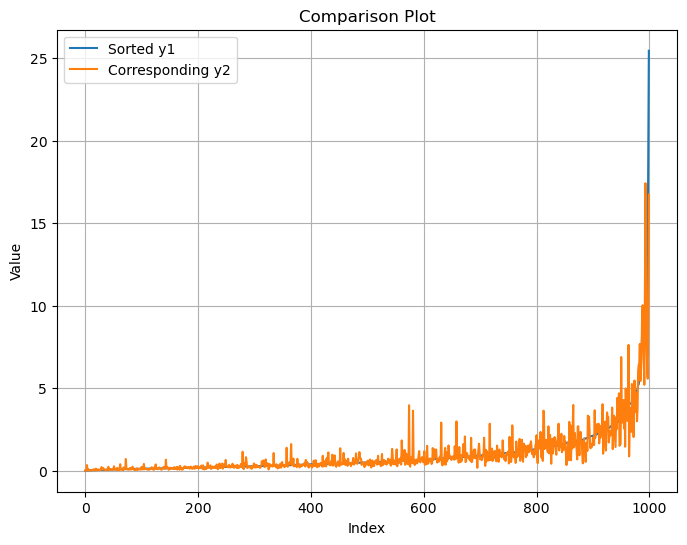

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example data # Example x values
y1 = true_z_dr  # Example y1 values (sin function)
y2 = est_z_dr  # Example y2 values (cos function)


# Rank y1 and maintain correspondence with y2
sorted_indices = np.argsort(y1)  # Get the indices that would sort y1
y1_sorted = y1[sorted_indices]  # Sort y1
y2_sorted = y2[sorted_indices]  # Sort y2 based on the sorted indices of y1

y1_sorted = y1_sorted[:1000]
y2_sorted = y2_sorted[:1000]
# Plotting
plt.figure(figsize=(8, 6))  # Set the figure size
plt.plot(y1_sorted, label='Sorted y1')  # Plot sorted y1
plt.plot(y2_sorted, label='Corresponding y2')  # Plot corresponding y2
plt.xlabel('Index')  # Set x-axis label
plt.ylabel('Value')  # Set y-axis label
plt.title('Comparison Plot')  # Set plot title
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()  # Display the plot


## 4. Test the entire algorithm

In [436]:
ns, p,q = 1000, 5, 10
nt = 1000

s = np.array([-1, -0.5, 0, 1, 1.5])
t = np.array([ -1, -1, 0.5 , 0.5, 1])
u = np.array([ 0, -1, 0.5, -0.5, 1])
def true_density_ratio(X, Z, V, s=s, t=t,\
                       p=5,q=10, Alpha_s = 0, Alpha_t = 2,z_diff = 0.1):
    ratios = []
    size = V.size
    for i in range(size):
        zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
        vs_prob = norm.pdf(V[i], loc=Z[i][:p]@s + Alpha_s*X[i], scale =5)
        zt_prob = multivariate_normal.pdf(Z[i][:p], mean = z_diff*np.ones(p), cov= 1*np.identity(p))
        vt_prob = norm.pdf(V[i], loc=Z[i][:p]@t + Alpha_t*X[i], scale =5)
        ratios.append((zt_prob*vt_prob)/(zs_prob*vs_prob))
    
    return np.array(ratios)
Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, Alpha_s=0, Alpha_t = 5,effect=2, z_diff = 0.2)
            

In [437]:
proportion = 0.5
num = int(proportion * X_source.shape[0])
Z_e = Z_source[:num]
X_e = X_source[:num]
V_e = V_source[:num]
Z_source = Z_source[num+1:]
X_source = X_source[num+1:]
V_source = V_source[num+1:]
Y_source = Y_source[num+1:]



In [438]:
Test_pe(X_e, Z_e, V_e, X_source, Z_source, V_source, Y_source, X_target, Z_target, V_target, L=3, K=20, datatype='binary')

/Users/bowenxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training accuracy for X|Z: 0.718
[0.44360394 0.34706114 0.46486182]
[135.76641675 182.83208479 198.76229492]


0.10292440518412249

In [377]:
model = est_x(X_e, Z_e, datatype = 'binary')
_,test_statistic = PCRtest(Y_source, X_source, Z_source, V_source,model_X_binary, model=model,density_ratio=None, L=3, K=20,covariate_shift=False)
chi_squared_p_value(test_statistic, 2)

/Users/bowenxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training accuracy for X|Z: 0.75


0.14128163068104094

In [273]:
# Test the true density ratio
def true_modelX(z, model=None):
    # Conditional distribution of X|Z
    value = z[:p] @ u + np.random.normal(0, 1, 1)
    x = (np.random.rand(1) < 1 / (1 + np.exp(-value))).astype(int)
    return x

Test_true_dr(X_source, Z_source, V_source, Y_source, X_target, Z_target, V_target, model_X = true_modelX,model=None,L=3, K=20, true_dr = true_density_ratio)

[3.57639351]
[295.47739615 343.2039034  357.98007709]


0.07628735033593093

In [275]:
c=0
for i in range(100):
    Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u,Alpha_s=0, Alpha_t = 2,effect=2, z_diff = 0.1)
    
    p_value = Test_true_dr(X_source, Z_source, V_source, Y_source, X_target, Z_target, V_target, model_X = true_modelX,model=None,L=3, K=20, true_dr = true_density_ratio)
    print(p_value)
    if p_value < 0.05:
        c += 1

[4.76619179]
[341.48627286 349.57157416 328.20948915]
0.7161530819989855
[4.4190899]
[303.45952121 361.41500082 342.14185884]
0.12986342587417976
[4.36540935]
[299.58293718 346.38000712 359.12511238]
0.0982414149108819
[5.11143005]
[316.95213739 342.27630682 348.68650151]
0.5296354049302836
[3.42053053]
[312.70865317 325.89082178 352.41857995]
0.3624864206556836
[3.38456646]
[298.31073416 362.49614222 332.43064195]
0.07010667506571733
[5.29293863]
[340.56704831 338.29475972 331.5310944 ]
0.9627435580226086
[4.87113071]
[326.95434103 337.95570304 365.9237406 ]
0.30714585962025964
[4.12066394]
[307.11727407 305.34877686 369.42903799]
0.027387469405503184
[4.77247736]
[331.22606992 305.85019058 371.89905851]
0.07109103634089164
[5.17133139]
[305.48061661 344.24156643 343.77519103]
0.3049942940569971
[4.05709336]
[340.8810377  348.27088323 312.45441375]
0.4387864394195953
[4.04896493]
[307.29498453 362.12011739 342.01229893]
0.1634969203738451
[3.17339817]
[342.70567605 335.68976639 299.12

KeyboardInterrupt: 

In [ ]:
print(c)